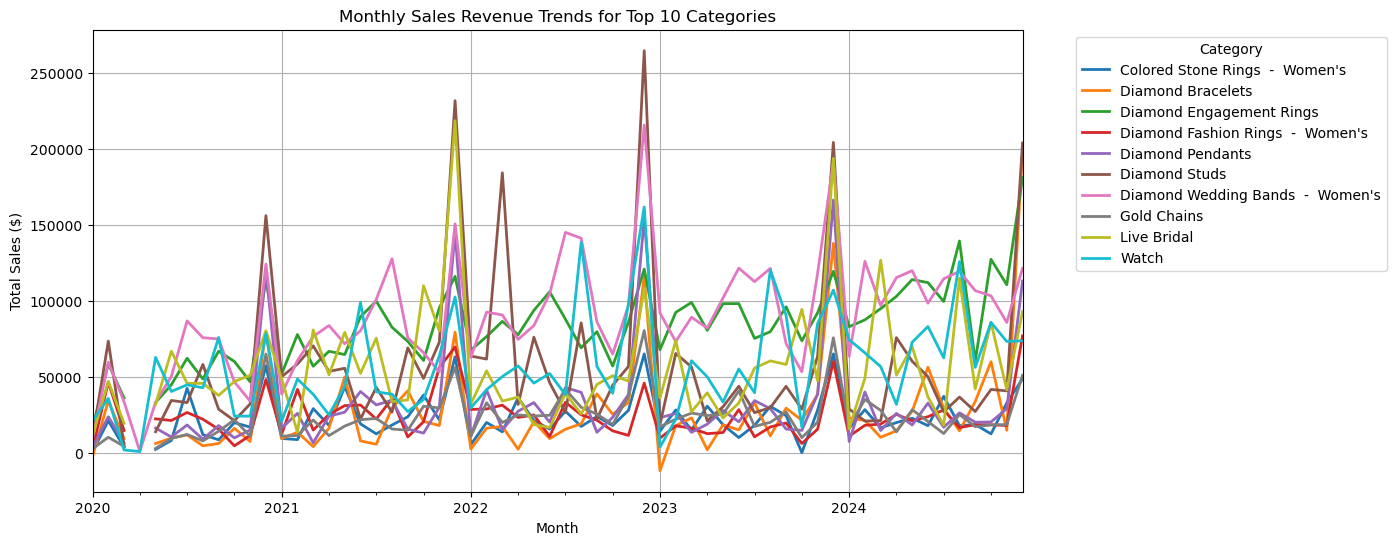

In [3]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np


# Initialize BigQuery client
client = bigquery.Client()

# Define the query to get monthly sales revenue for the top 10 categories
query = """
WITH top_categories AS (
    SELECT category_name, SUM(sale_total) AS total_sales
    FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
    GROUP BY category_name
    ORDER BY total_sales DESC
    LIMIT 10
)
SELECT 
    DATE_TRUNC(sold_date, MONTH) AS month,
    category_name,
    SUM(sale_total) AS total_sales
FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
WHERE category_name IN (SELECT category_name FROM top_categories)
GROUP BY month, category_name
ORDER BY month, category_name;
"""

# Run the query
df = client.query(query).to_dataframe()

# Convert month to datetime format
df['month'] = pd.to_datetime(df['month'])

# Pivot for visualization
df_pivot = df.pivot(index="month", columns="category_name", values="total_sales")

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df_pivot.plot(ax=plt.gca(), linewidth=2)
plt.title("Monthly Sales Revenue Trends for Top 10 Categories")
plt.xlabel("Month")
plt.ylabel("Total Sales ($)")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show plot
plt.show()


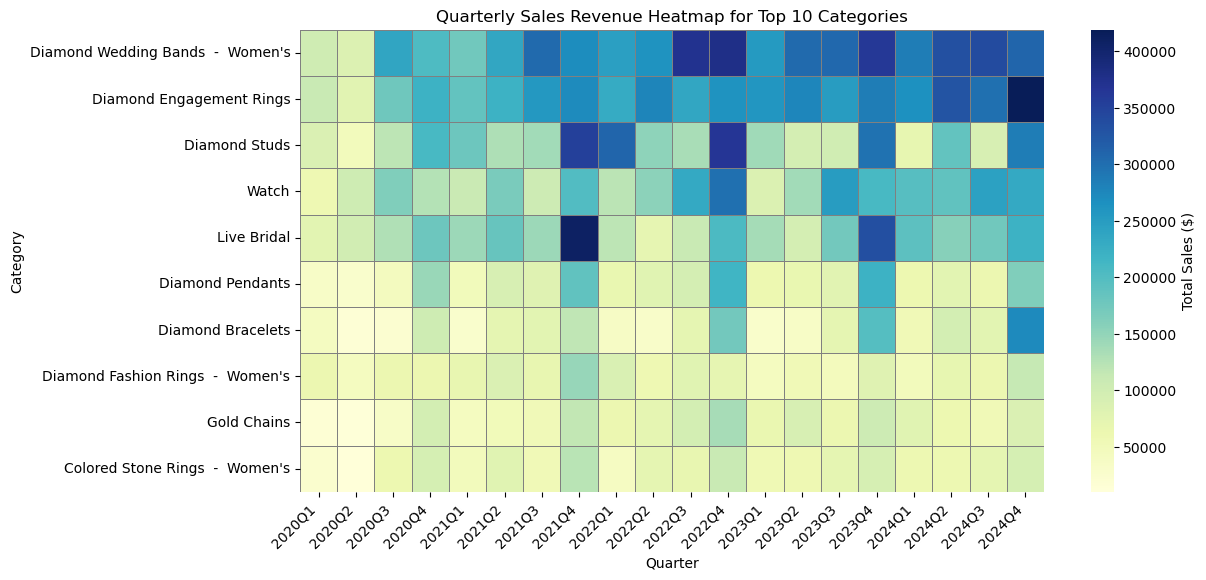

In [4]:
# Convert 'month' column to datetime if not already
df['month'] = pd.to_datetime(df['month'])

# Aggregate to quarterly data
df['quarter'] = df['month'].dt.to_period('Q')
df_quarterly = df.groupby(['quarter', 'category_name'])['total_sales'].sum().reset_index()

# Determine total sales per category for sorting
category_sales_rank = df_quarterly.groupby('category_name')['total_sales'].sum().sort_values(ascending=False).index

# Pivot for heatmap (sorted categories)
df_heatmap = df_quarterly.pivot(index="category_name", columns="quarter", values="total_sales")
df_heatmap = df_heatmap.loc[category_sales_rank]  # Sort categories by total sales

# Set up the figure size
plt.figure(figsize=(12, 6))

# Create heatmap
sns.heatmap(df_heatmap, cmap="YlGnBu", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Total Sales ($)'})

# Formatting
plt.title("Quarterly Sales Revenue Heatmap for Top 10 Categories")
plt.xlabel("Quarter")
plt.ylabel("Category")

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.show()



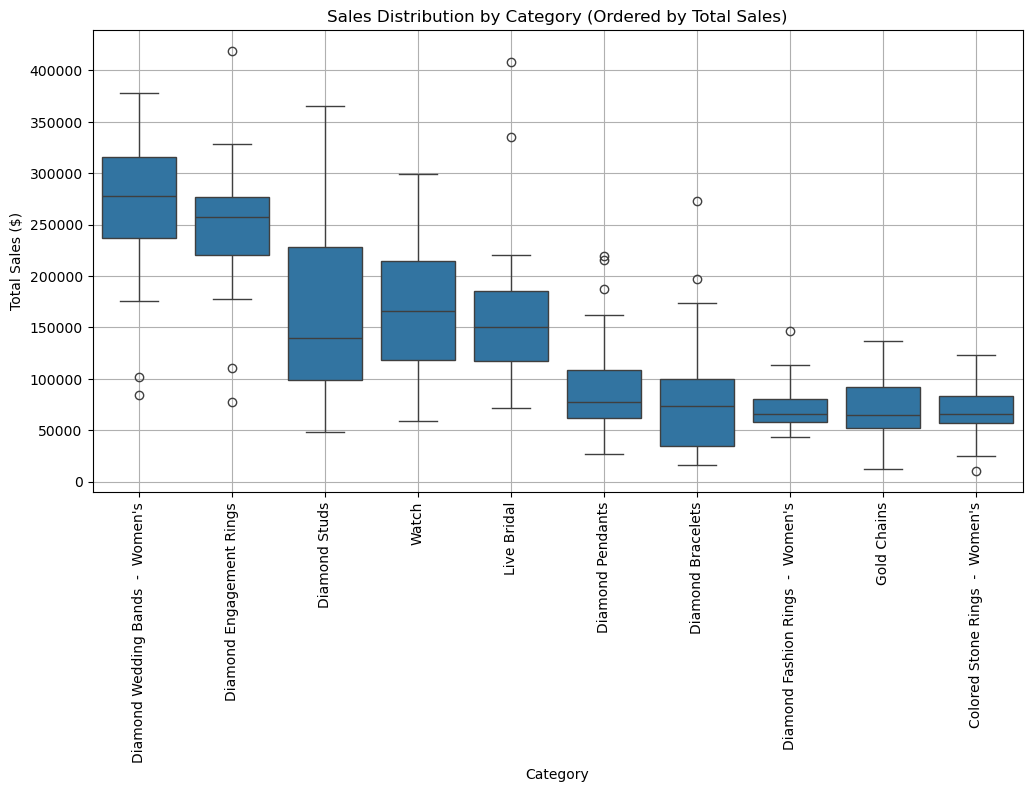

Identified Outliers (Z-score > 3 or < -3):


NameError: name 'df_outliers' is not defined

In [5]:
# Compute total sales per category for sorting
category_sales_rank = df_quarterly.groupby("category_name")["total_sales"].sum().sort_values(ascending=False).index

# Set category order based on total sales
plt.figure(figsize=(12, 6))
sns.boxplot(x="category_name", y="total_sales", data=df_quarterly, order=category_sales_rank)

# Formatting
plt.xticks(rotation=90)
plt.title("Sales Distribution by Category (Ordered by Total Sales)")
plt.xlabel("Category")
plt.ylabel("Total Sales ($)")
plt.grid(True)

# Show plot
plt.show()

# Display outliers
print("Identified Outliers (Z-score > 3 or < -3):")
print(df_outliers[["quarter", "category_name", "total_sales", "z_score"]])


## Identifying Key Trends:
### Top-Selling Categories:
Women's Diamond Wedding Bands and Diamond Engagement Rings have the highest median sales and significant variability. These categories are contributing the most to overall revenue.

### Mid-Range Performers:
Diamond Studs, Watches, Live Bridal, and Diamond Pendants also have high median sales, but with more spread (variation) between quarters.

### Lower-Selling Categories:
Gold Chains, Women's Diamond Fashion Rings and Women's Colored Stone Rings have the lowest median sales, meaning they contribute less to total revenue of the top 10 categories.

## Understanding Oultiers & Variability:
### Large Spreads (High Variability in Sales)
- Diamond Studs, Watches, and Live Bridal show larger interquartile ranges (IQRs), indicating fluctuating demand between quarters.
- These categories may be harder to forecast because their sales are less consistent.
### Frequent Outliers (Spikes in Sales)
- Outliers (points above the whiskers) suggest quarters where sales surged unexpectedly.
- Women's Diamond Wedding Bands, Diamond Engagement Rings and Watches show several high ouliers, like due to seasonal spikes, e.g. holiday shopping in Q4.
### Consisten Performers (Lower Variability)
- Gold Chains and Women's Colored Stone Rings have smaller IQRs, meaning their sales are more stable over time.
- these categories are likely easier to forecast,

### Interpreting the Identified Outlier:
The Z-score analysis flagged Q4 2021 for "Diamond Fashion Rings - Women's" as a statistical outlier.

## What does this mean? 
- Q4 2021 (October-December '21)
- Category: Women's Diamond Fashion Rings
- Total Sales: $146,005.35
- Z-score: 3.04 - This means the sales in this quarter were more than 3 standard deviations above the mean for this category.

## Why is this an outlier?
- A Z-score above 3 indicates that this sales value is significantly higher than the typical sales for this cateory.
- This suggests a spike in demand that is not consistent with previous quarters.

## Possible reasons for the spike?
- Historically strong quarter for jewelry sales due to the holidays (Black Friday, Christmas, engagement season).
- Economic Factors - did consumer spending on luxury items increase in late 2021?
- One-off Large Purchases? A few high-value transactions could have pushed up sales.

## Impact on Forecasting:
- Adjust for Seasonality: If this spike is seasonal, the model should incorporate seasonality.
- Handle Anomalies Carefully: If this was a one-time event, using raw historial data could lead to overestimated forecasts.
- Compare to Other Q4s: Checking sales for Q4 in other years will help determine if htis is a recurring trend or a true anomaly.

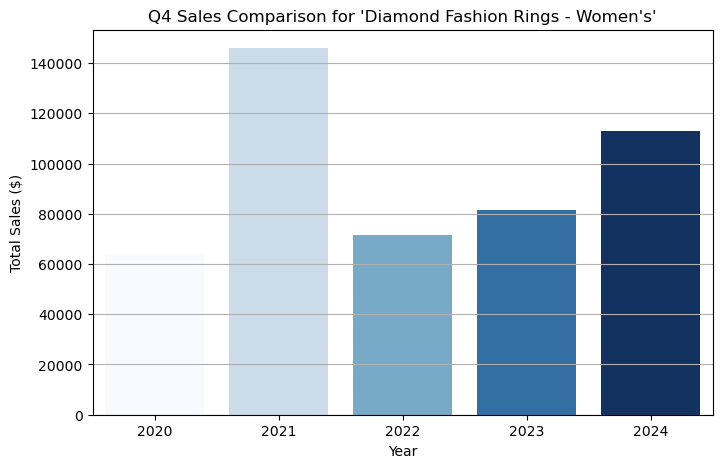

   year                      category_name  total_sales
0  2020  Diamond Fashion Rings  -  Women's     64099.11
1  2021  Diamond Fashion Rings  -  Women's    146005.35
2  2022  Diamond Fashion Rings  -  Women's     71621.20
3  2023  Diamond Fashion Rings  -  Women's     81537.60
4  2024  Diamond Fashion Rings  -  Women's    113159.47


In [6]:
query = """
SELECT 
    year,
    category_name,
    SUM(sale_total) AS total_sales
FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
WHERE quarter LIKE 'Oct%'
AND category_name = "Diamond Fashion Rings  -  Women's"  -- Using double quotes
GROUP BY year, category_name
ORDER BY year;
"""

# Run the query
df_q4_comparison = client.query(query).to_dataframe()

# Plot Q4 sales comparison over years
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Q4 sales comparison over years
plt.figure(figsize=(8, 5))
sns.barplot(x="year", y="total_sales", hue="year", data=df_q4_comparison, palette="Blues", legend=False)

# Formatting
plt.title("Q4 Sales Comparison for 'Diamond Fashion Rings - Women's'")
plt.xlabel("Year")
plt.ylabel("Total Sales ($)")
plt.grid(axis="y")

# Show plot
plt.show()

# Display the Q4 sales comparison data
print(df_q4_comparison)



## Key Takeaways
### Biggest Spike: Q4 2021 ($146,005.35)
- Q4 2021 stands out as an anomaly, with significantly higher sales compared to other years.
- This supports our earlier Z-score analysis that flagged it as an outlier.
### Post-2021 Dip & Recovery:
- Sales dropped sharply in 2022 ($71,621.20) after the 2021 spike.
- Sales recovered in 2023 ($81,537.60) and jumped again in 2024 ($113,159.47).

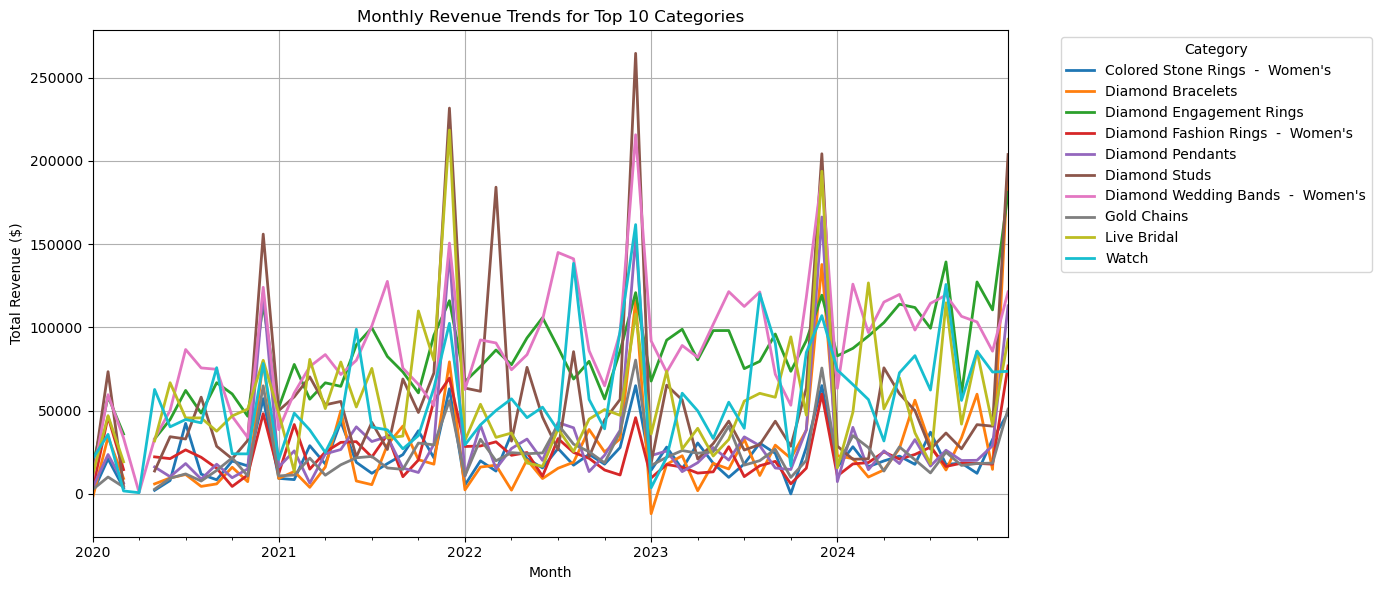

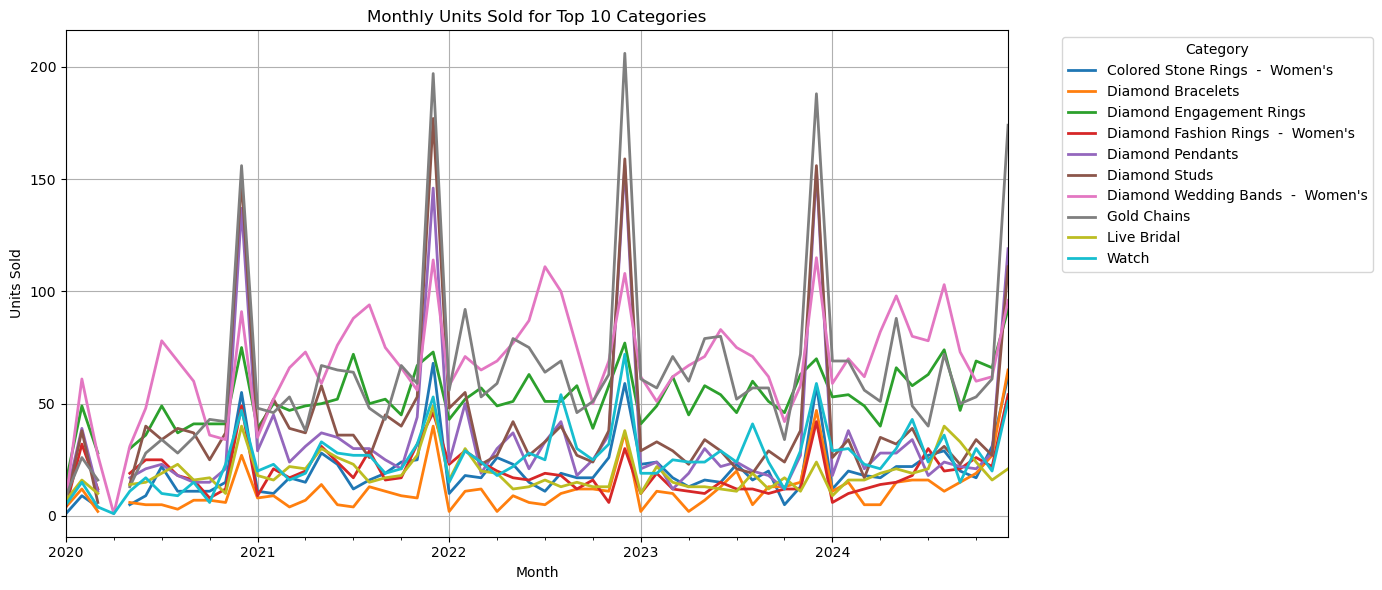

In [7]:
# Query definition
query = """
WITH top_categories AS (
  SELECT category_name
  FROM (
    SELECT category_name, SUM(sale_total) AS total_sales
    FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
    WHERE sold_date BETWEEN '2020-01-01' AND '2024-12-31'
    GROUP BY category_name
    ORDER BY total_sales DESC
    LIMIT 10
  )
)

SELECT
  DATE_TRUNC(sold_date, MONTH) AS month,
  category_name,
  COUNT(DISTINCT sku) AS items_sold,
  ROUND(SUM(sale_total), 2) AS total_revenue
FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
WHERE sold_date BETWEEN '2020-01-01' AND '2024-12-31'
  AND category_name IN (SELECT category_name FROM top_categories)
GROUP BY month, category_name
ORDER BY month, category_name;
"""

df = client.query(query).to_dataframe()

# Convert 'month' column to datetime
df['month'] = pd.to_datetime(df['month'])

# Create pivot tables for each metric
df_pivot_revenue = df.pivot(index='month', columns='category_name', values='total_revenue')
df_pivot_units = df.pivot(index='month', columns='category_name', values='items_sold')

# ---- Plot 1: Monthly Revenue Trends ----
plt.figure(figsize=(14, 6))
df_pivot_revenue.plot(ax=plt.gca(), linewidth=2)
plt.title("Monthly Revenue Trends for Top 10 Categories")
plt.xlabel("Month")
plt.ylabel("Total Revenue ($)")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Plot 2: Monthly Units Sold Trends ----
plt.figure(figsize=(14, 6))
df_pivot_units.plot(ax=plt.gca(), linewidth=2)
plt.title("Monthly Units Sold for Top 10 Categories")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

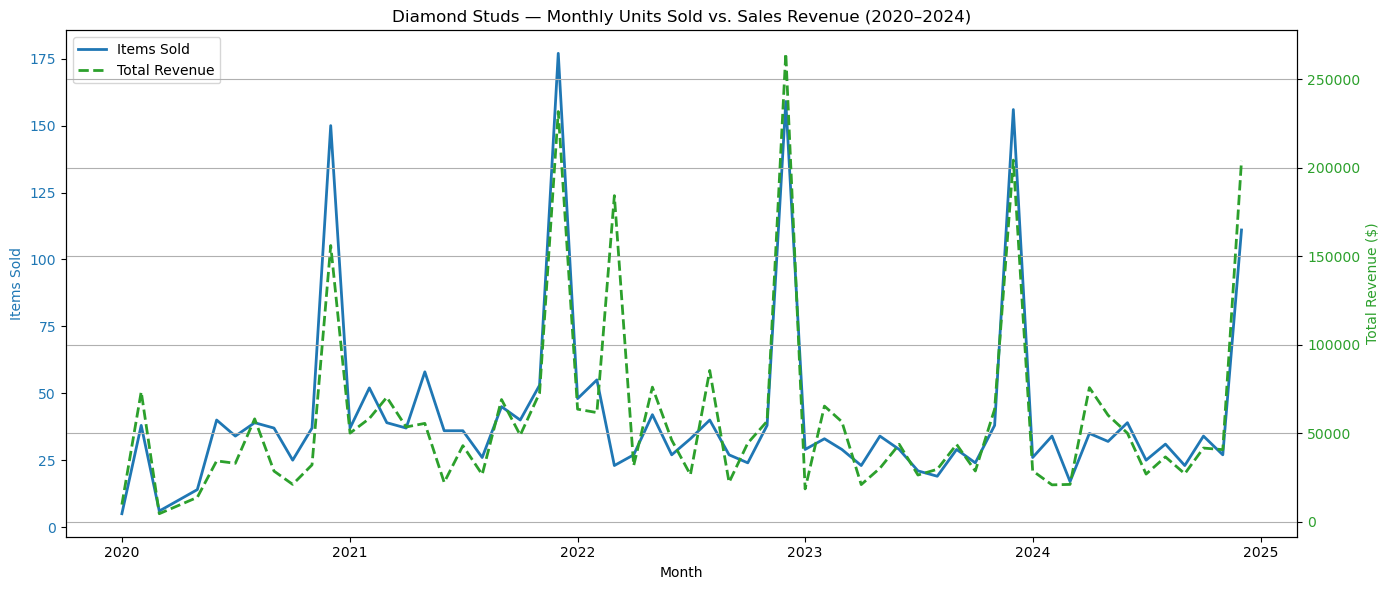

In [8]:
# Filter to just one category
category_name = "Diamond Studs"
df_filtered = df[df['category_name'] == category_name].copy()
df_filtered['month'] = pd.to_datetime(df_filtered['month'])

# Sort by month in case it's not sorted
df_filtered = df_filtered.sort_values('month')

# Set up dual-axis plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot items sold (left y-axis)
color = 'tab:blue'
ax1.set_xlabel("Month")
ax1.set_ylabel("Items Sold", color=color)
ax1.plot(df_filtered['month'], df_filtered['items_sold'], color=color, label='Items Sold', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)

# Create right y-axis for revenue
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel("Total Revenue ($)", color=color)
ax2.plot(df_filtered['month'], df_filtered['total_revenue'], color=color, linestyle='dashed', label='Total Revenue', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

# Title and formatting
plt.title(f"{category_name} — Monthly Units Sold vs. Sales Revenue (2020–2024)")
fig.tight_layout()

# Optional combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.grid(True)
plt.show()

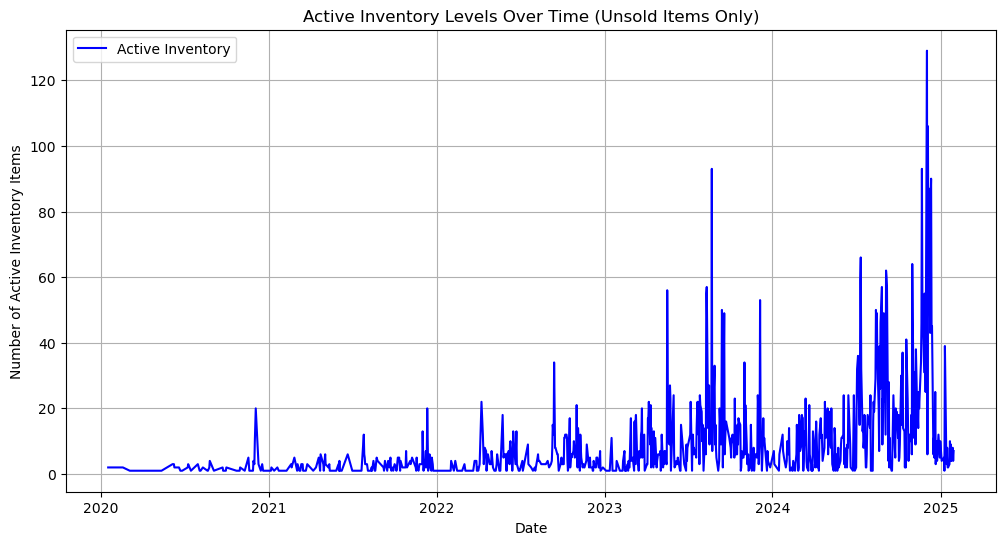

In [9]:
# Query to fetch active inventory over time (only unsold items)
query = """
SELECT 
    DATE(purchase_date) AS date,
    COUNT(sku) AS active_inventory_count
FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
WHERE sold_status = 0  -- Only count inventory still in stock
AND purchase_date >= '2020-01-01'  -- Limit to 2020-2024 data
GROUP BY date
ORDER BY date;
"""

# Run the query
df_active_inventory = client.query(query).to_dataframe()

# Convert 'date' to datetime format
df_active_inventory['date'] = pd.to_datetime(df_active_inventory['date'])

# Plot the active inventory levels over time
plt.figure(figsize=(12, 6))
plt.plot(df_active_inventory['date'], df_active_inventory['active_inventory_count'], color='b', label="Active Inventory")

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Number of Active Inventory Items")
plt.title("Active Inventory Levels Over Time (Unsold Items Only)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

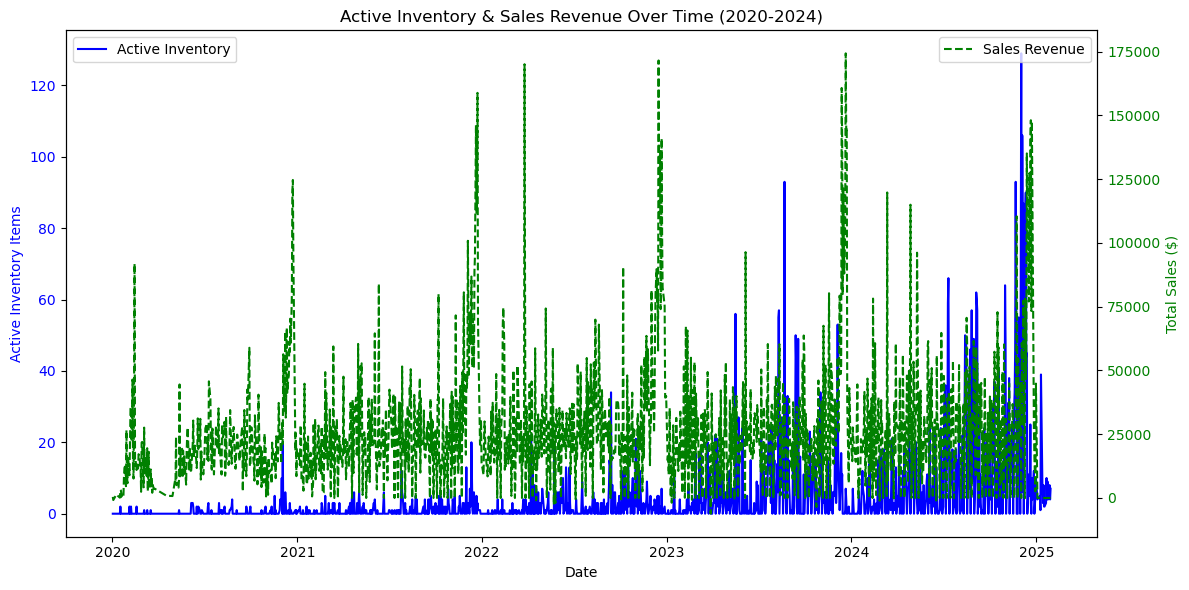

In [10]:
# Query to fetch sales revenue over time
query_sales = """
SELECT 
    DATE(sold_date) AS date,
    SUM(sale_total) AS total_sales
FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
WHERE sold_date >= '2020-01-01'  -- Limit to 2020-2024 data
GROUP BY date
ORDER BY date;
"""

# Run the query for sales
df_sales = client.query(query_sales).to_dataframe()

# Convert 'date' to datetime format
df_sales['date'] = pd.to_datetime(df_sales['date'])

# Merge sales and active inventory data on 'date'
df_inventory_sales = pd.merge(df_active_inventory, df_sales, on='date', how='outer').fillna(0)

# Plot the active inventory levels and sales trends
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Active Inventory (Left Y-Axis)
ax1.set_xlabel("Date")
ax1.set_ylabel("Active Inventory Items", color="b")
ax1.plot(df_inventory_sales['date'], df_inventory_sales['active_inventory_count'], color="b", label="Active Inventory")
ax1.tick_params(axis="y", labelcolor="b")

# Plot Sales Revenue (Right Y-Axis)
ax2 = ax1.twinx()
ax2.set_ylabel("Total Sales ($)", color="g")
ax2.plot(df_inventory_sales['date'], df_inventory_sales['total_sales'], color="g", linestyle="dashed", label="Sales Revenue")
ax2.tick_params(axis="y", labelcolor="g")

# Title and legend
plt.title("Active Inventory & Sales Revenue Over Time (2020-2024)")
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Show the plot
plt.show()


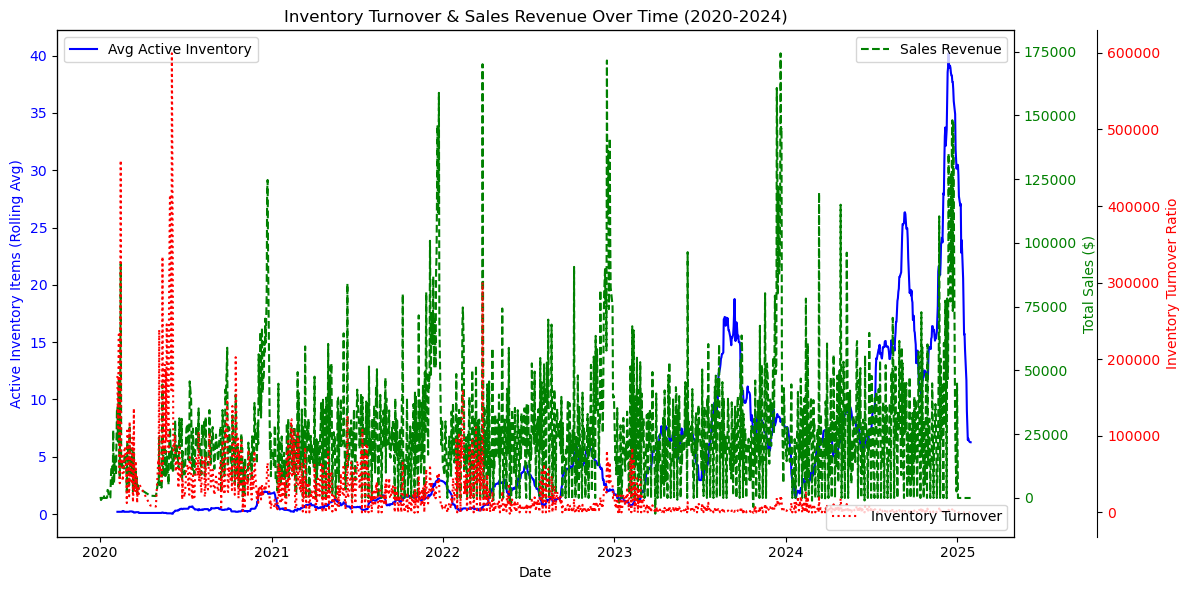

In [11]:
# Query to fetch sales revenue over time
query_sales = """
SELECT 
    DATE(sold_date) AS date,
    SUM(sale_total) AS total_sales
FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
WHERE sold_date >= '2020-01-01'  -- Limit to 2020-2024 data
GROUP BY date
ORDER BY date;
"""

# Run the query for sales
df_sales = client.query(query_sales).to_dataframe()
df_sales['date'] = pd.to_datetime(df_sales['date'])

# Query to fetch cumulative active inventory levels over time
query_inventory = """
SELECT 
    DATE(purchase_date) AS date,
    SUM(CASE WHEN sold_status = 0 THEN 1 ELSE 0 END) AS active_inventory_count
FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
WHERE purchase_date >= '2020-01-01'  -- Limit to 2020-2024 data
GROUP BY date
ORDER BY date;
"""

# Run the query for active inventory
df_active_inventory = client.query(query_inventory).to_dataframe()
df_active_inventory['date'] = pd.to_datetime(df_active_inventory['date'])

# Merge sales and active inventory data on 'date'
df_inventory_sales = pd.merge(df_active_inventory, df_sales, on='date', how='outer').fillna(0)

# **Compute a Rolling 30-Day Average for Active Inventory**
df_inventory_sales['avg_active_inventory'] = df_inventory_sales['active_inventory_count'].rolling(window=30).mean()

# **Calculate Inventory Turnover Ratio**
df_inventory_sales['inventory_turnover'] = df_inventory_sales['total_sales'] / df_inventory_sales['avg_active_inventory']

# Plot the active inventory levels, sales trends, and inventory turnover
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Active Inventory (Left Y-Axis)
ax1.set_xlabel("Date")
ax1.set_ylabel("Active Inventory Items (Rolling Avg)", color="b")
ax1.plot(df_inventory_sales['date'], df_inventory_sales['avg_active_inventory'], color="b", label="Avg Active Inventory")
ax1.tick_params(axis="y", labelcolor="b")

# Plot Sales Revenue (Right Y-Axis)
ax2 = ax1.twinx()
ax2.set_ylabel("Total Sales ($)", color="g")
ax2.plot(df_inventory_sales['date'], df_inventory_sales['total_sales'], color="g", linestyle="dashed", label="Sales Revenue")
ax2.tick_params(axis="y", labelcolor="g")

# Plot Inventory Turnover (Dashed Line)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Offset third y-axis
ax3.set_ylabel("Inventory Turnover Ratio", color="r")
ax3.plot(df_inventory_sales['date'], df_inventory_sales['inventory_turnover'], color="r", linestyle="dotted", label="Inventory Turnover")
ax3.tick_params(axis="y", labelcolor="r")

# Title and legend
plt.title("Inventory Turnover & Sales Revenue Over Time (2020-2024)")
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax3.legend(loc="lower right")

# Show the plot
plt.show()


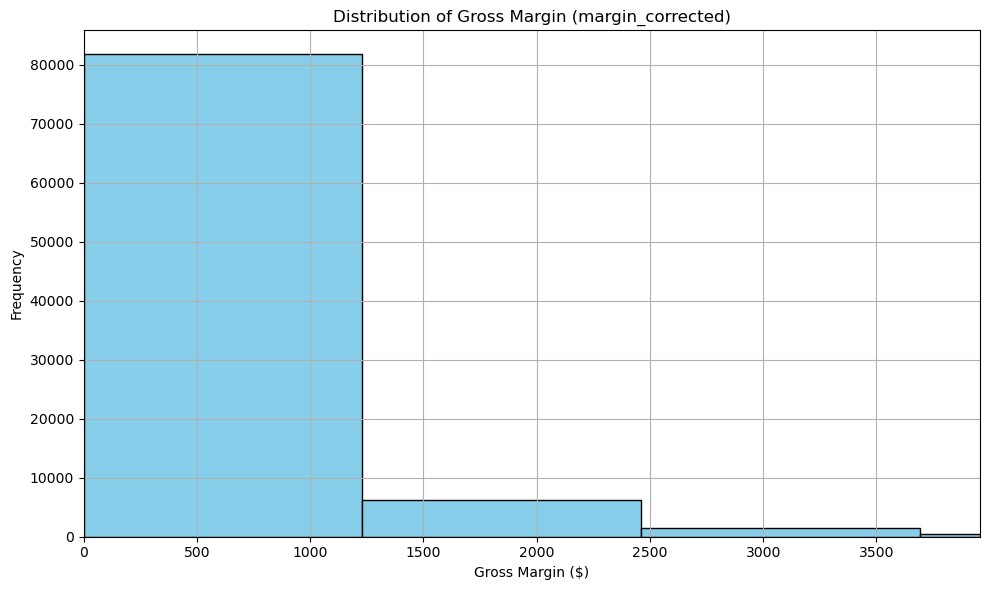

In [12]:


# Query to get margin_corrected values
query = """
    SELECT SAFE_CAST(margin_corrected AS FLOAT64) AS margin_corrected
    FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
    WHERE SAFE_CAST(margin_corrected AS FLOAT64) IS NOT NULL
"""

# Load the data into a DataFrame
df = client.query(query).to_dataframe()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['margin_corrected'], bins=100, edgecolor='black', color='skyblue')
plt.title('Distribution of Gross Margin (margin_corrected)')
plt.xlabel('Gross Margin ($)')
plt.ylabel('Frequency')
plt.xlim(0, df['margin_corrected'].quantile(0.99))  # Zoom in to exclude extreme outliers
plt.grid(True)
plt.tight_layout()
plt.show()


count: 90088
mean: 272.24
median: 129.0
stddev: 388.51
min: 0
max: 6593
90th_percentile: 720.0
95th_percentile: 1007.0
99th_percentile: 1792.0
over_1_year: 25.09
over_2_years: 9.79


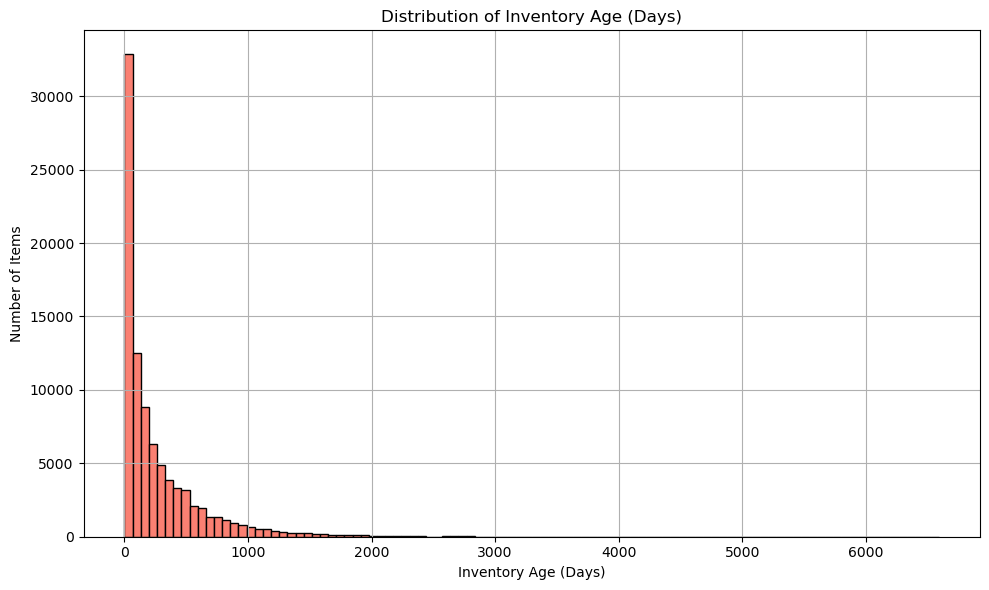

In [13]:
# Step 1: Load inventory age data
query = """
    SELECT SAFE_CAST(age_inventory_days AS INT64) AS age_days
    FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
    WHERE SAFE_CAST(age_inventory_days AS INT64) IS NOT NULL
"""
df = client.query(query).to_dataframe()

# Step 2: Filter out negative ages (data issues)
df = df[df['age_days'] >= 0]

# Step 3: Calculate robust summary statistics
age_stats = {
    "count": len(df),
    "mean": df['age_days'].mean(),
    "median": df['age_days'].median(),
    "stddev": df['age_days'].std(),
    "min": df['age_days'].min(),
    "max": df['age_days'].max(),
    "90th_percentile": df['age_days'].quantile(0.90),
    "95th_percentile": df['age_days'].quantile(0.95),
    "99th_percentile": df['age_days'].quantile(0.99),
    "over_1_year": (df['age_days'] > 365).mean() * 100,
    "over_2_years": (df['age_days'] > 730).mean() * 100
}

# Step 4: Print the stats
for k, v in age_stats.items():
    print(f"{k}: {round(v, 2)}")

# Step 5: Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['age_days'], bins=100, color='salmon', edgecolor='black')
plt.title("Distribution of Inventory Age (Days)")
plt.xlabel("Inventory Age (Days)")
plt.ylabel("Number of Items")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Step 1: Query margin + key identifying fields
query = """
    SELECT 
        sku,
        vendor,
        style,
        category_name,
        SAFE_CAST(margin_corrected AS FLOAT64) AS margin_corrected,
        SAFE_CAST(margin_percent AS FLOAT64) AS margin_percent,
        SAFE_CAST(cost AS FLOAT64) AS cost,
        SAFE_CAST(saleprice AS FLOAT64) AS saleprice,
        SAFE_CAST(age_inventory_days AS INT64) AS age_inventory_days
    FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
    WHERE SAFE_CAST(margin_corrected AS FLOAT64) IS NOT NULL
"""

df = client.query(query).to_dataframe()

# Step 2: Filter to only valid margin rows
df = df[df['margin_corrected'].notna()]

# Step 3: Calculate 90th percentile
margin_cutoff = df['margin_corrected'].quantile(0.90)
print(f"90th percentile gross margin: ${round(margin_cutoff, 2)}")

# Step 4: Filter top 10% margin items
top_10_margin_df = df[df['margin_corrected'] > margin_cutoff]

# Optional: Sort and preview
top_10_margin_df = top_10_margin_df.sort_values(by='margin_corrected', ascending=False)
print(top_10_margin_df.head(10))

# Optional: Export to CSV
# top_10_margin_df.to_csv("top_10_percent_margin_inventory.csv", index=False)


90th percentile gross margin: $1197.5
                   sku vendor                style  \
8554     003-105-03399    JDC            CU900DEF2   
8493     001-105-03345    XLD                70492   
29705    001-155-04392    JDC        LIGHTNING 700   
8704     002-105-01881    JDC  EXCEPTIONAL3.52FMPT   
35385    001-170-01558    GAB       BG3968-65W45JJ   
8529   001-105-3000002   PREM                 AR19   
8586   001-105-3000013    JDC       E3SEM400TPS090   
42821    001-270-00474    ATL                12194   
40655    001-230-01709    ADG           ADG913645V   
38101    001-200-03108    JYE              RB38504   

                       category_name  margin_corrected  margin_percent  \
8554                     Live Bridal         123055.64          0.4102   
8493                     Live Bridal          65100.00          0.3426   
29705                  Diamond Studs          55027.00          0.4046   
8704                     Live Bridal          37568.00          0.3795 

Number of categories that make up 80% of gross sales: 11


category_name  sale_total  cumulative_sales  \
0   Diamond Wedding Bands  -  Women's  5371265.21        5371265.21   
1            Diamond Engagement Rings  4914262.59       10285527.80   
2                       Diamond Studs  3495649.96       13781177.76   
3                               Watch  3388387.84       17169565.60   
4                         Live Bridal  3353807.11       20523372.71   
5                    Diamond Pendants  1910806.39       22434179.10   
6                   Diamond Bracelets  1629648.72       24063827.82   
7   Diamond Fashion Rings  -  Women's  1424570.50       25488398.32   
8                         Gold Chains  1405898.35       26894296.67   
9     Colored Stone Rings  -  Women's  1359167.02       28253463.69   
10       Gold Wedding Bands  -  Men's  1314879.18       29568342.87   
11                   Diamond Earrings  1265861.93       30834204.80   
12              Colored Stone Pendant   989005.16       31823209.96   
13           Colored Stones  -  Loose   797937.21       32621147.17   
14            Alternative Metal Bands   719422.19       33340569.36   

    cumulative_percent  
0            13.938283  
1            26.690656  
2            35.761770  
3            44.554541  
4            53.257576  
5            58.216065  
6            62.444958  
7            66.141679  
8            69.789945  
9            73.316946  
10           76.729020  
11           80.013896  
12           82.580337  
13           84.650962  
14           86.517842

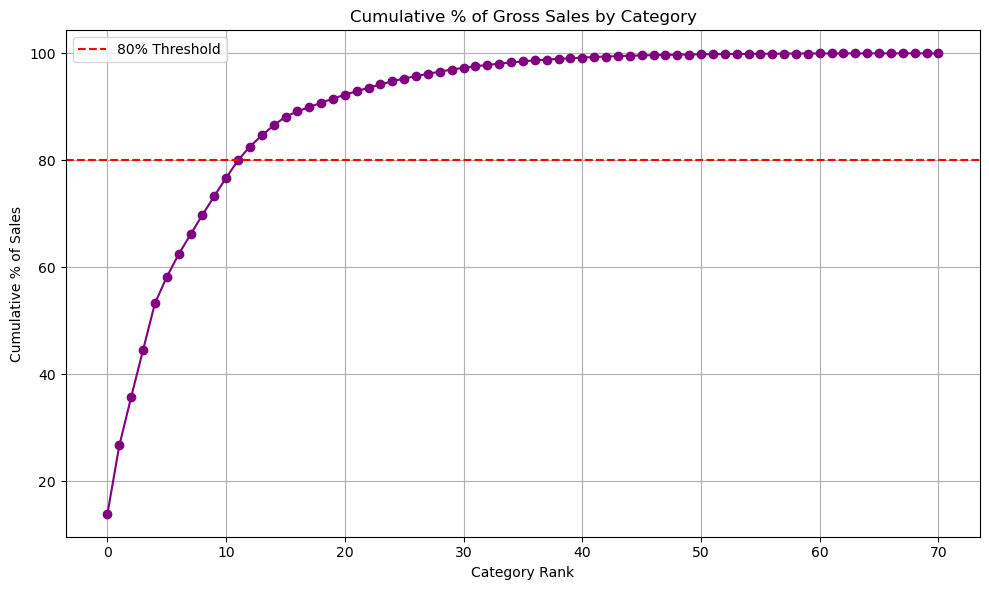

In [15]:
# Step 1: Query sales data by category
query = """
    SELECT 
        category_name,
        SAFE_CAST(sale_total AS FLOAT64) AS sale_total
    FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
    WHERE category_name IS NOT NULL AND SAFE_CAST(sale_total AS FLOAT64) IS NOT NULL
"""
df = client.query(query).to_dataframe()

# Step 2: Aggregate sales by category
category_sales = df.groupby('category_name', as_index=False)['sale_total'].sum()

# Step 3: Sort by total sales descending
category_sales = category_sales.sort_values(by='sale_total', ascending=False).reset_index(drop=True)

# Step 4: Calculate cumulative sales and % of total
category_sales['cumulative_sales'] = category_sales['sale_total'].cumsum()
total_sales = category_sales['sale_total'].sum()
category_sales['cumulative_percent'] = category_sales['cumulative_sales'] / total_sales * 100

# Step 5: Identify categories contributing to 80% of total sales
top_categories = category_sales[category_sales['cumulative_percent'] <= 80]

# Display result
print(f"Number of categories that make up 80% of gross sales: {len(top_categories)}")
display(category_sales.head(15))  # View top categories and their % contributions

# Optional: Plot the Pareto curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(category_sales['cumulative_percent'], marker='o', color='purple')
plt.axhline(80, color='red', linestyle='--', label='80% Threshold')
plt.title('Cumulative % of Gross Sales by Category')
plt.xlabel('Category Rank')
plt.ylabel('Cumulative % of Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Number of categories that make up 80% of gross sales: 11


category_num                      category_name  sale_total  \
0           110  Diamond Wedding Bands  -  Women's  5371265.21   
1           100           Diamond Engagement Rings  4914262.59   
2           155                      Diamond Studs  3495649.96   
3           560                              Watch  3388387.84   
4           105                        Live Bridal  3353807.11   
5           160                   Diamond Pendants  1910806.39   
6           170                  Diamond Bracelets  1629648.72   
7           130  Diamond Fashion Rings  -  Women's  1424570.50   
8           430                        Gold Chains  1405898.35   
9           200    Colored Stone Rings  -  Women's  1359167.02   
10          405       Gold Wedding Bands  -  Men's  1314879.18   
11          150                   Diamond Earrings  1265861.93   
12          230              Colored Stone Pendant   989005.16   
13          270           Colored Stones  -  Loose   797937.21   
14          945            Alternative Metal Bands   719422.19   

    cumulative_sales  cumulative_percent  
0         5371265.21           13.938283  
1        10285527.80           26.690656  
2        13781177.76           35.761770  
3        17169565.60           44.554541  
4        20523372.71           53.257576  
5        22434179.10           58.216065  
6        24063827.82           62.444958  
7        25488398.32           66.141679  
8        26894296.67           69.789945  
9        28253463.69           73.316946  
10       29568342.87           76.729020  
11       30834204.80           80.013896  
12       31823209.96           82.580337  
13       32621147.17           84.650962  
14       33340569.36           86.517842

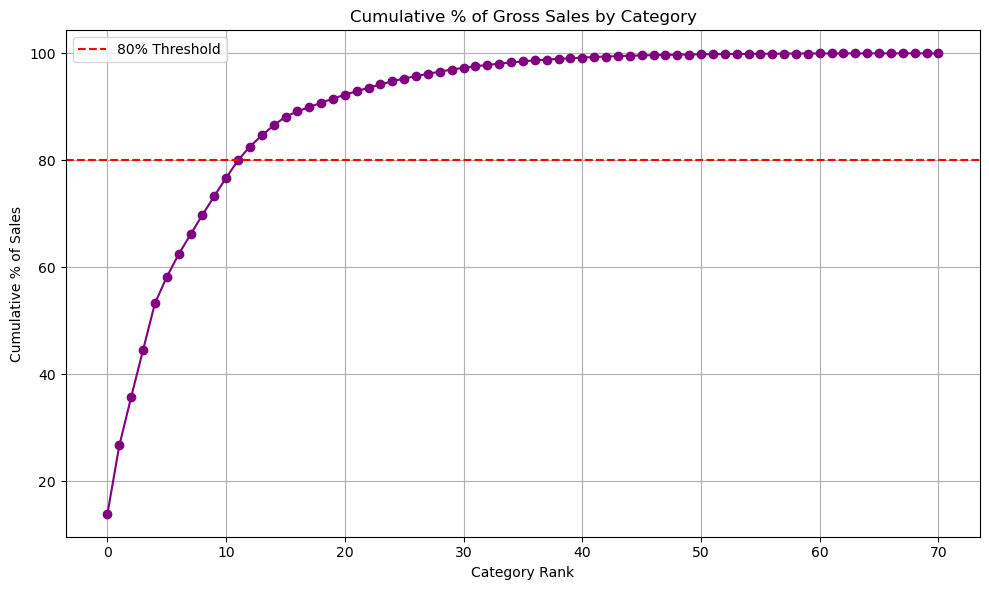

In [16]:
# Step 1: Query sales data by category name and number
query = """
    SELECT 
        category_num,
        category_name,
        SAFE_CAST(sale_total AS FLOAT64) AS sale_total
    FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
    WHERE category_name IS NOT NULL 
      AND category_num IS NOT NULL
      AND SAFE_CAST(sale_total AS FLOAT64) IS NOT NULL
"""
df = client.query(query).to_dataframe()

# Step 2: Aggregate sales by category number and name
category_sales = df.groupby(['category_num', 'category_name'], as_index=False)['sale_total'].sum()

# Step 3: Sort by total sales descending
category_sales = category_sales.sort_values(by='sale_total', ascending=False).reset_index(drop=True)

# Step 4: Calculate cumulative sales and % of total
category_sales['cumulative_sales'] = category_sales['sale_total'].cumsum()
total_sales = category_sales['sale_total'].sum()
category_sales['cumulative_percent'] = category_sales['cumulative_sales'] / total_sales * 100

# Step 5: Identify categories contributing to 80% of total sales
top_categories = category_sales[category_sales['cumulative_percent'] <= 80]

# Display result
print(f"Number of categories that make up 80% of gross sales: {len(top_categories)}")
display(category_sales.head(15))  # View top categories and their % contributions

# Optional: Plot the Pareto curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(category_sales['cumulative_percent'], marker='o', color='purple')
plt.axhline(80, color='red', linestyle='--', label='80% Threshold')
plt.title('Cumulative % of Gross Sales by Category')
plt.xlabel('Category Rank')
plt.ylabel('Cumulative % of Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have this DataFrame from earlier
top11 = category_sales.head(11).copy()

# Format numbers for display
top11['sale_total'] = top11['sale_total'].apply(lambda x: f"${x:,.2f}")
top11['cumulative_sales'] = top11['cumulative_sales'].apply(lambda x: f"${x:,.2f}")
top11['cumulative_percent'] = top11['cumulative_percent'].apply(lambda x: f"{x:.2f}%")

# Rename columns for display
top11.columns = ['Category', 'Total Sales', 'Cumulative Sales', 'Cumulative % of Sales']

# Plot table using matplotlib
fig, ax = plt.subplots(figsize=(12, 5))  # Adjust size as needed
ax.axis('off')
table = ax.table(
    cellText=top11.values,
    colLabels=top11.columns,
    loc='center',
    cellLoc='center',
    colLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)  # Adjust cell size (width, height)

# Optional: Style headers and cells
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#4B72B0')  # header background
    else:
        cell.set_facecolor('#F4F4F4' if row % 2 == 0 else '#FFFFFF')  # zebra striping


plt.title("Top 11 Categories by Total Sales", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig("top_11_categories_table.png", dpi=300, bbox_inches='tight')
plt.show()


ValueError: Length mismatch: Expected axis has 5 elements, new values have 4 elements

Side-by-side comparison of Facebook Prophet model, and SARIMA model

In [19]:
!pip install prophet

In [20]:
# Use Live Bridal to forecast 1 category

query = """
SELECT 
  period AS ds,
  total_sales AS y
FROM `capstone-project-2025-449217.jdc_data.top11_forecast_sales`
WHERE category_name = 'Live Bridal'
ORDER BY ds
"""
df = client.query(query).to_dataframe()


10:46:52 - cmdstanpy - INFO - Chain [1] start processing
10:46:52 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper
59 2025-01-01   63605.271076   35698.916768   93224.191124
60 2025-02-01   38185.928428    9534.487411   67921.177848
61 2025-03-01   68234.343701   36115.919531   99240.119253
62 2025-04-01   47562.230508   16919.972543   77514.024084
63 2025-05-01   53447.986907   22064.197129   83676.934903
64 2025-06-01   49609.233417   18340.120410   81591.186179
65 2025-07-01   53160.495008   22498.979130   84602.556082
66 2025-08-01   66444.542351   34497.878814   94202.238744
67 2025-09-01   51394.962395   21298.239816   82293.237831
68 2025-10-01   86325.971912   54895.185142  118835.625452
69 2025-11-01   63283.212393   32306.248798   93911.839551
70 2025-12-01  143092.849119  113028.409606  173338.792805


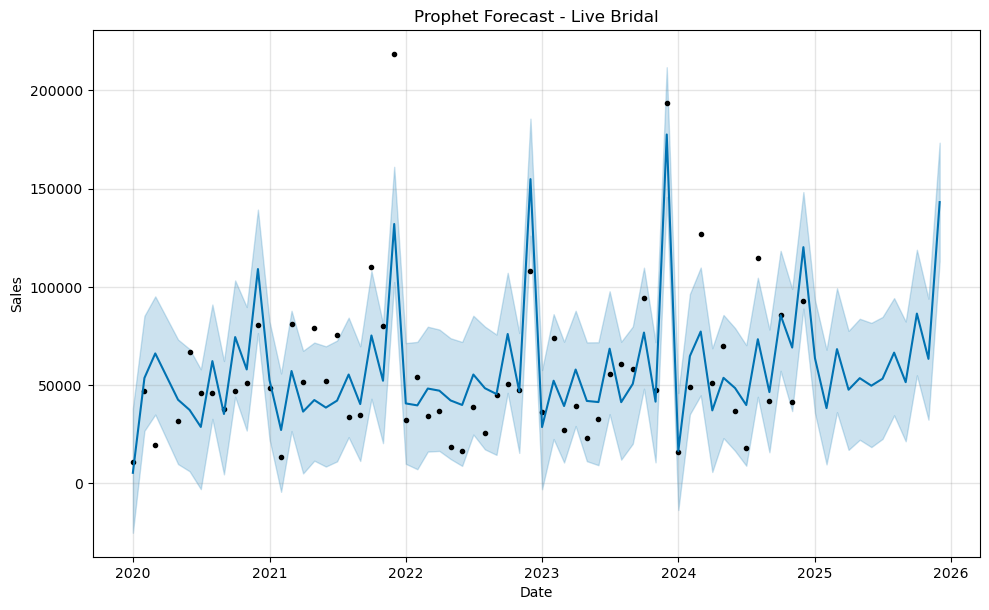

In [21]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Initialize and fit Prophet model
model_prophet = Prophet()
model_prophet.fit(df)

# Make future dataframe and forecast
future = model_prophet.make_future_dataframe(periods=12, freq='MS')
forecast_prophet = model_prophet.predict(future)

# Filter only forecasted months (not historical fit)
latest_ds = pd.to_datetime(df['ds'].max())
forecast_only = forecast_prophet[forecast_prophet['ds'] > latest_ds][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


# (Optional) Display or save the forecast
print(forecast_only)

# Plot Prophet forecast
fig1 = model_prophet.plot(forecast_prophet)
plt.title("Prophet Forecast - Live Bridal")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


/Users/juliehilley/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.48885D+00    |proj g|=  4.50813D-02

At iterate    5    f=  9.45829D+00    |proj g|=  3.43030D-02

At iterate   10    f=  9.45458D+00    |proj g|=  1.40445D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     18      1     0     0   7.837D-06   9.455D+00
  F =   9.4545492115782377     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
           ds           yhat    yhat_lower     yhat_upper
0  2025-01-0

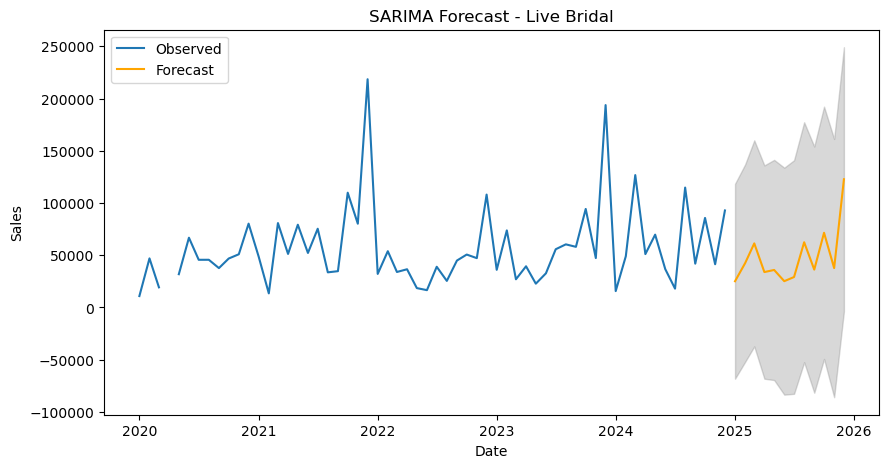

In [22]:
# Forecast with SARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Set datetime index and frequency
df_sarima = df.set_index('ds').asfreq('MS')

# Fit SARIMA model
model_sarima = SARIMAX(df_sarima['y'], order=(1,1,1), seasonal_order=(1,1,1,12))
results_sarima = model_sarima.fit()

# Forecast next 12 months
forecast_sarima = results_sarima.get_forecast(steps=12)
predicted_mean = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()

# Combine forecast into a single DataFrame
df_sarima_forecast = predicted_mean.to_frame(name='yhat')
df_sarima_forecast['yhat_lower'] = conf_int.iloc[:, 0]
df_sarima_forecast['yhat_upper'] = conf_int.iloc[:, 1]
df_sarima_forecast.index.name = 'ds'
df_sarima_forecast.reset_index(inplace=True)

# (Optional) Print or export
print(df_sarima_forecast)
# df_sarima_forecast.to_csv("live_bridal_sarima_forecast.csv", index=False)

# Plot SARIMA forecast
plt.figure(figsize=(10,5))
plt.plot(df_sarima['y'], label='Observed')
plt.plot(predicted_mean.index, predicted_mean, label='Forecast', color='orange')
plt.fill_between(predicted_mean.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='gray', alpha=0.3)
plt.legend()
plt.title("SARIMA Forecast - Live Bridal")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


Evaluate the forecasting performance of the above models using two common metrics:
    
MAPE (Mean Absolute Percentage Error)	Measures average absolute percent error. Easy to interpret — “X% off on average.”
RMSE (Root Mean Squared Error)	Penalizes large errors more than MAPE. Good when large spikes are important.

In [24]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np


In [25]:
# Evaluate Prophet
# Ensure both 'ds' columns are datetime64[ns]
df['ds'] = pd.to_datetime(df['ds'])
forecast_prophet['ds'] = pd.to_datetime(forecast_prophet['ds'])

# Now merge safely
df_eval_prophet = pd.merge(df, forecast_prophet[['ds', 'yhat']], on='ds', how='left')

# Calculate metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

mape_prophet = mean_absolute_percentage_error(df_eval_prophet['y'], df_eval_prophet['yhat']) * 100
rmse_prophet = np.sqrt(mean_squared_error(df_eval_prophet['y'], df_eval_prophet['yhat']))

print(f"📊 Prophet Performance (In-Sample):")
print(f"MAPE: {mape_prophet:.2f}%")
print(f"RMSE: ${rmse_prophet:,.2f}")



📊 Prophet Performance (In-Sample):
MAPE: 41.36%
RMSE: $24,017.56


In [26]:
# Evaluate SARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Predict in-sample values from SARIMA
sarima_fitted = results_sarima.fittedvalues

# Align actuals with fitted values
df_eval_sarima = df_sarima.copy()
df_eval_sarima['yhat'] = sarima_fitted

# Drop missing values from early differencing periods
df_eval_sarima = df_eval_sarima.dropna()

# Calculate metrics
mape_sarima = mean_absolute_percentage_error(df_eval_sarima['y'], df_eval_sarima['yhat']) * 100
rmse_sarima = np.sqrt(mean_squared_error(df_eval_sarima['y'], df_eval_sarima['yhat']))

print(f"\n📊 SARIMA Performance (In-Sample):")
print(f"MAPE: {mape_sarima:.2f}%")
print(f"RMSE: ${rmse_sarima:,.2f}")



📊 SARIMA Performance (In-Sample):
MAPE: 72.52%
RMSE: $37,952.59


Loop through top 11 categories.

🔄 Running forecast for: Diamond Engagement Rings (category_num=100)


10:47:45 - cmdstanpy - INFO - Chain [1] start processing
10:47:45 - cmdstanpy - INFO - Chain [1] done processing


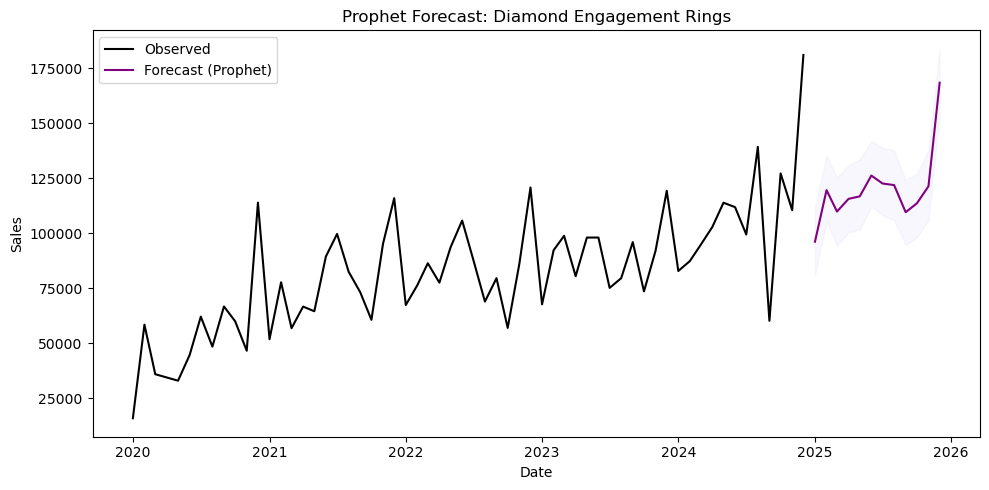

🔄 Running forecast for: Live Bridal (category_num=105)


10:47:48 - cmdstanpy - INFO - Chain [1] start processing
10:47:48 - cmdstanpy - INFO - Chain [1] done processing


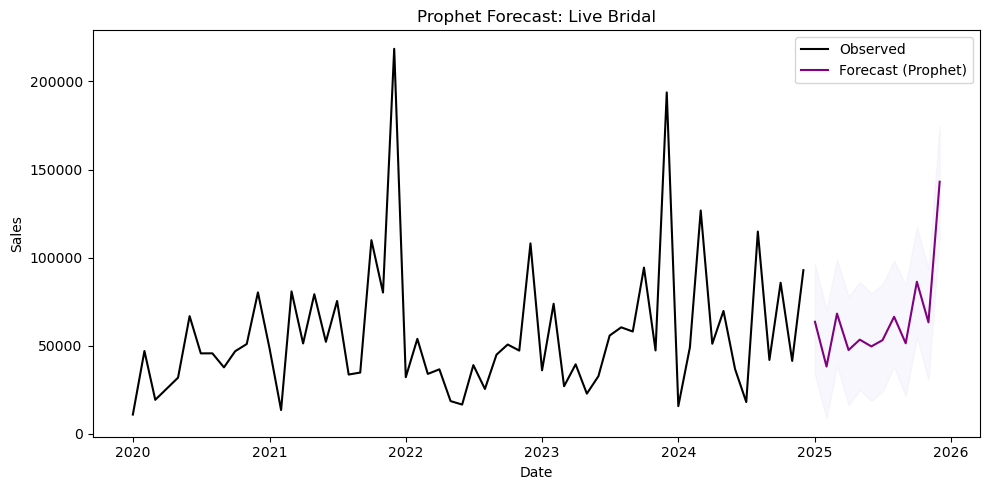

🔄 Running forecast for: Diamond Wedding Bands  -  Women's (category_num=110)


10:47:51 - cmdstanpy - INFO - Chain [1] start processing
10:47:51 - cmdstanpy - INFO - Chain [1] done processing


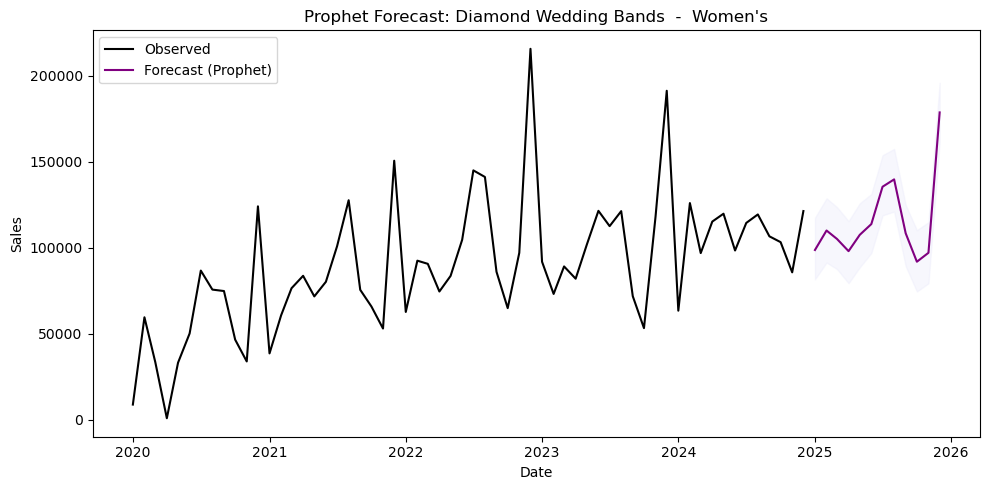

🔄 Running forecast for: Diamond Fashion Rings  -  Women's (category_num=130)


10:47:55 - cmdstanpy - INFO - Chain [1] start processing
10:47:55 - cmdstanpy - INFO - Chain [1] done processing


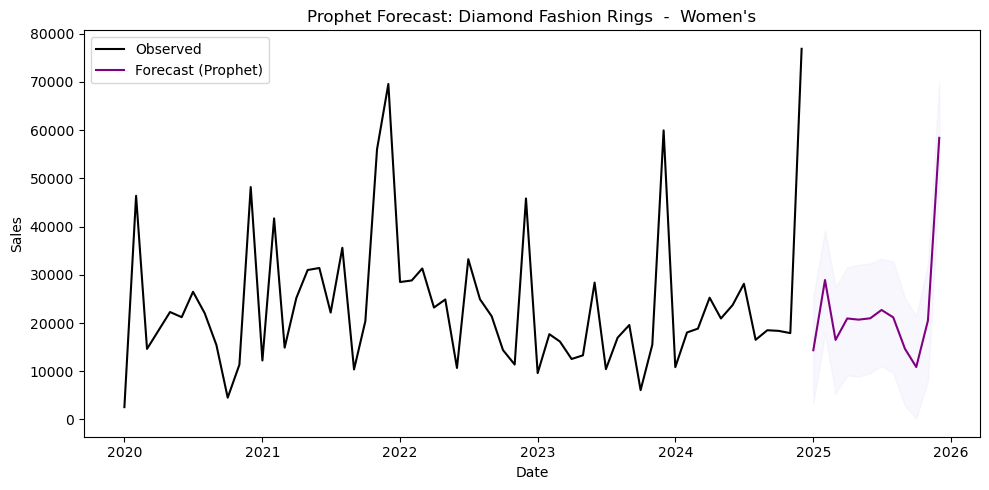

🔄 Running forecast for: Diamond Studs (category_num=155)


10:47:58 - cmdstanpy - INFO - Chain [1] start processing
10:47:58 - cmdstanpy - INFO - Chain [1] done processing


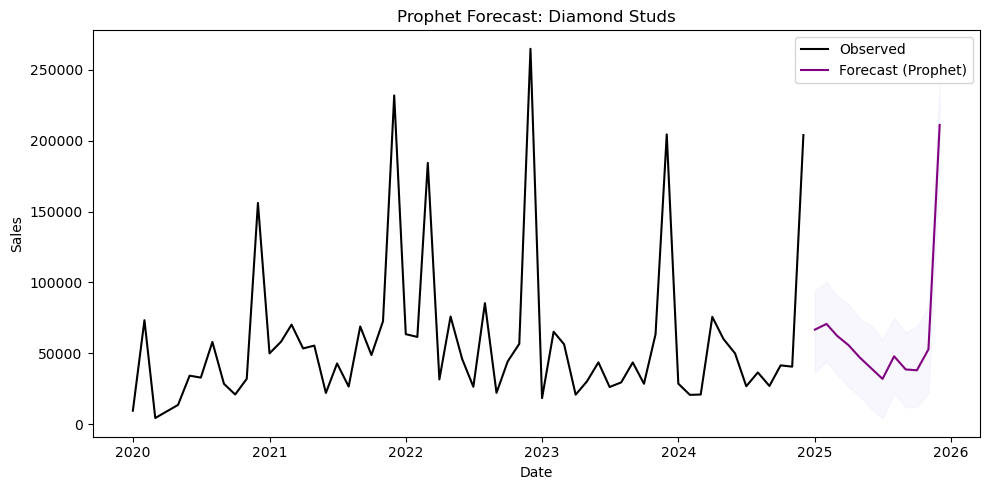

🔄 Running forecast for: Diamond Pendants (category_num=160)


10:48:01 - cmdstanpy - INFO - Chain [1] start processing
10:48:01 - cmdstanpy - INFO - Chain [1] done processing


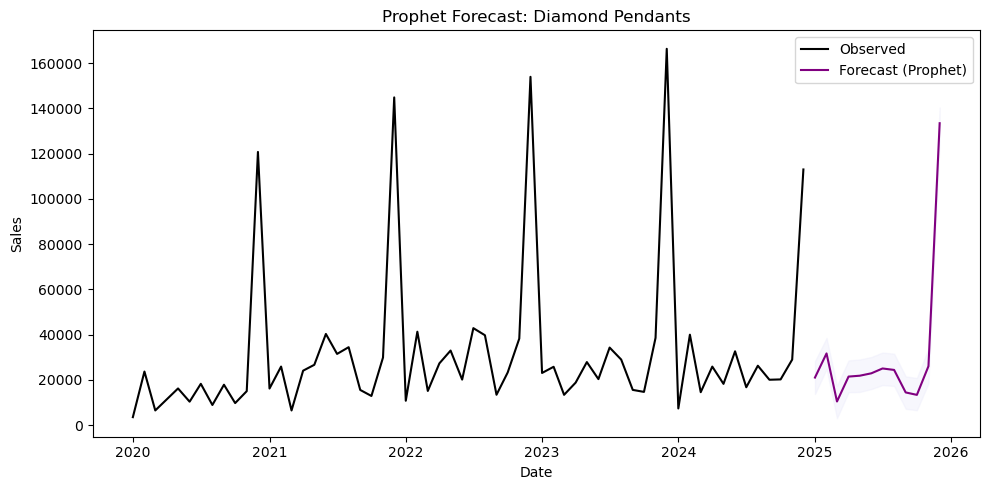

🔄 Running forecast for: Diamond Bracelets (category_num=170)


10:48:04 - cmdstanpy - INFO - Chain [1] start processing
10:48:04 - cmdstanpy - INFO - Chain [1] done processing


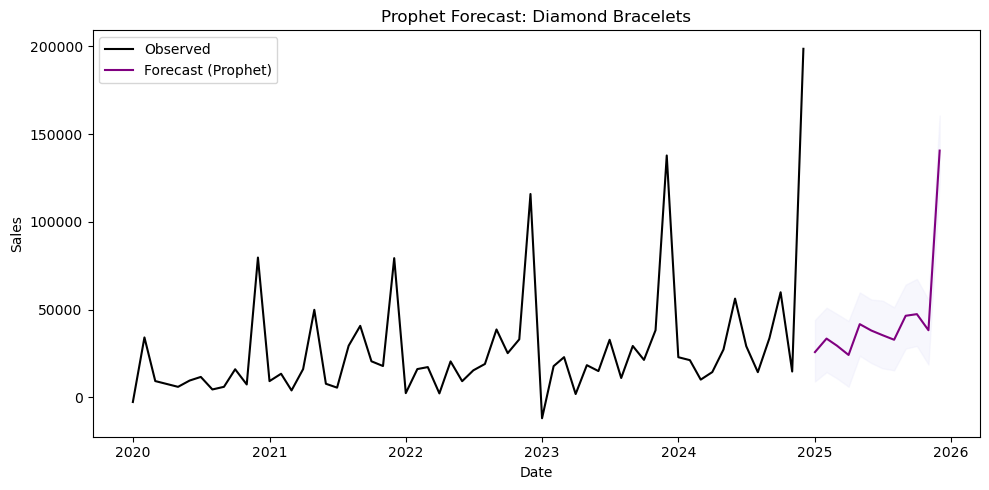

🔄 Running forecast for: Colored Stone Rings  -  Women's (category_num=200)


10:48:07 - cmdstanpy - INFO - Chain [1] start processing
10:48:07 - cmdstanpy - INFO - Chain [1] done processing


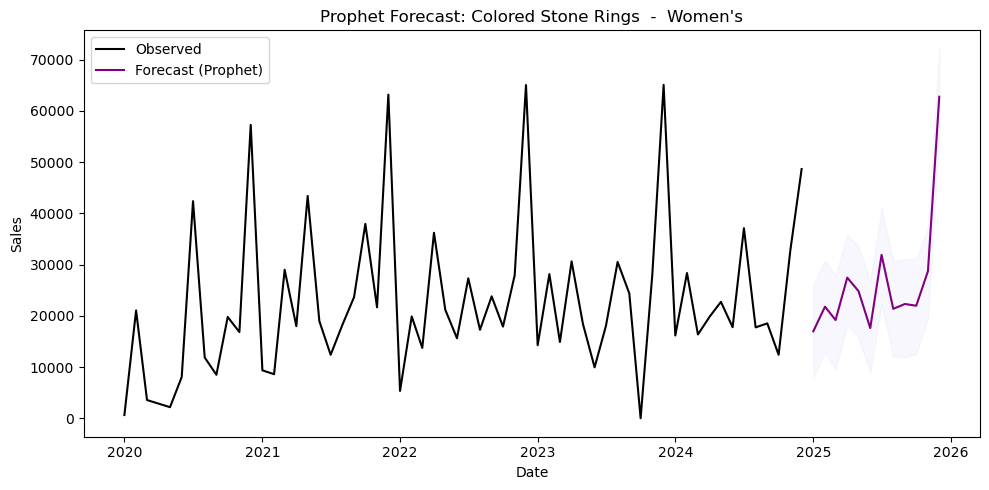

🔄 Running forecast for: Gold Wedding Bands  -  Men's (category_num=405)


10:48:10 - cmdstanpy - INFO - Chain [1] start processing
10:48:10 - cmdstanpy - INFO - Chain [1] done processing


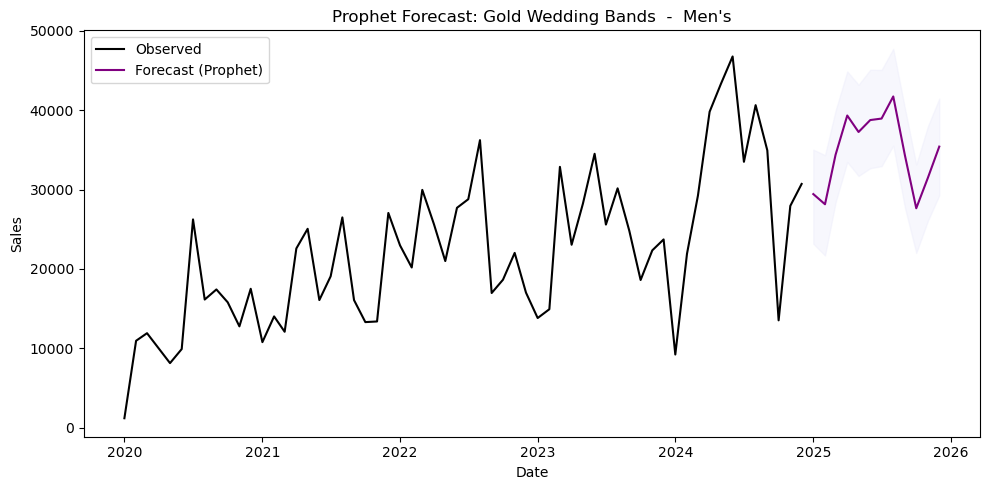

🔄 Running forecast for: Gold Chains (category_num=430)


10:48:13 - cmdstanpy - INFO - Chain [1] start processing
10:48:13 - cmdstanpy - INFO - Chain [1] done processing


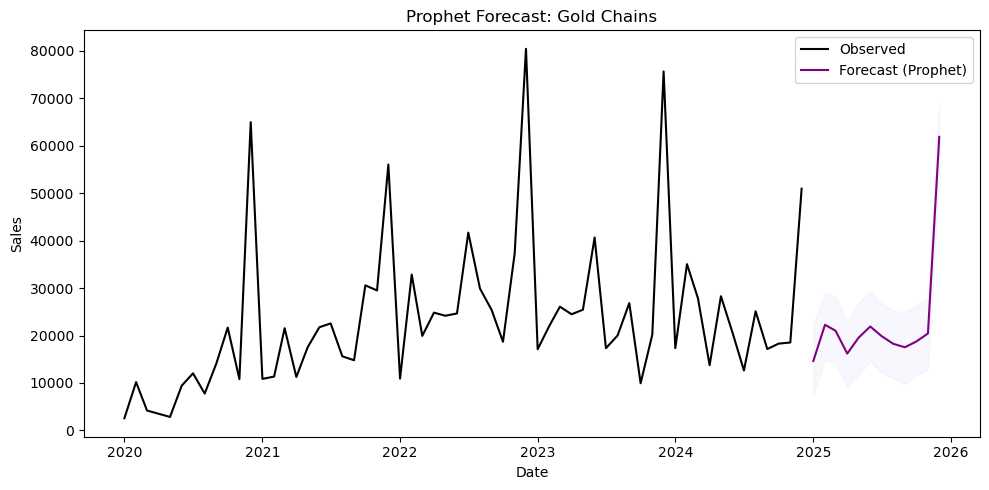

🔄 Running forecast for: Watch (category_num=560)


10:48:16 - cmdstanpy - INFO - Chain [1] start processing
10:48:16 - cmdstanpy - INFO - Chain [1] done processing


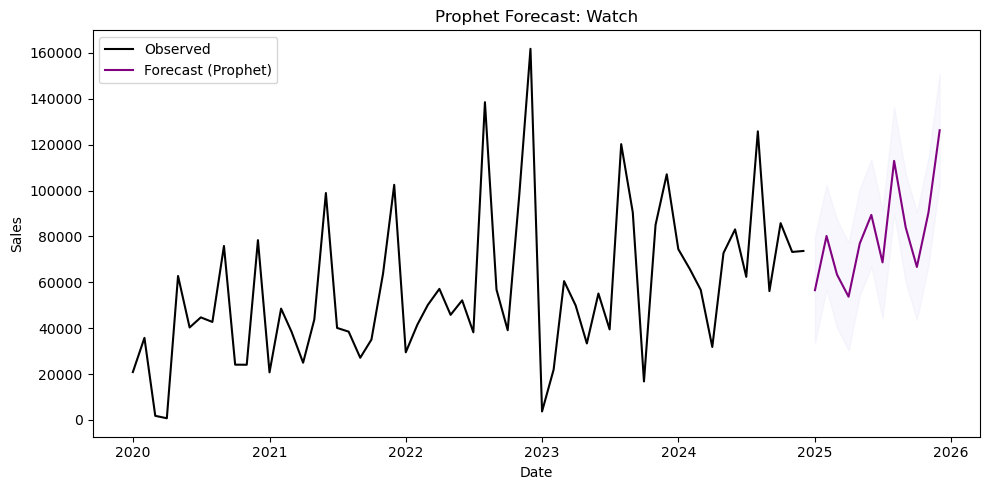

In [27]:
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt

# Load category list from BigQuery (to loop through)
query = """
    SELECT DISTINCT category_num, category_name
    FROM `capstone-project-2025-449217.jdc_data.top11_forecast_sales`
    ORDER BY category_num
"""
categories = client.query(query).to_dataframe()

# Store all forecasts
all_forecasts = []

for idx, row in categories.iterrows():
    category_num = row['category_num']
    category_name = row['category_name']

    print(f"🔄 Running forecast for: {category_name} (category_num={category_num})")

    # Query data for each category
    query = f"""
        SELECT 
            period AS ds,
            total_sales AS y
        FROM `capstone-project-2025-449217.jdc_data.top11_forecast_sales`
        WHERE category_num = '{category_num}'
        ORDER BY ds
    """
    df = client.query(query).to_dataframe()
    df['ds'] = pd.to_datetime(df['ds'])

    if len(df) < 24:
        print(f"⚠️ Skipping {category_name} — not enough data ({len(df)} rows)")
        continue

    # ==============================
    # 🔮 PROPHET MODEL FORECASTING
    # ==============================
    prophet_model = Prophet()
    prophet_model.fit(df)

    future = prophet_model.make_future_dataframe(periods=12, freq='MS')
    prophet_forecast = prophet_model.predict(future)

    # Extract only future values
    latest_ds = df['ds'].max()
    future_forecast = prophet_forecast[prophet_forecast['ds'] > latest_ds][
        ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
    ].copy()
    future_forecast['category_num'] = category_num
    future_forecast['category_name'] = category_name

    all_forecasts.append(future_forecast)

    # ==============================
    # 📈 OPTIONAL PLOT
    # ==============================
    plt.figure(figsize=(10, 5))
    plt.plot(df['ds'], df['y'], label='Observed', color='black')
    plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Forecast (Prophet)', color='purple')
    plt.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'],
                     alpha=0.3, color='lavender')
    plt.title(f"Prophet Forecast: {category_name}")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Concatenate all forecast results into a single DataFrame
forecast_results = pd.concat(all_forecasts, ignore_index=True)


Aggregated sales model.

10:48:27 - cmdstanpy - INFO - Chain [1] start processing
10:48:27 - cmdstanpy - INFO - Chain [1] done processing


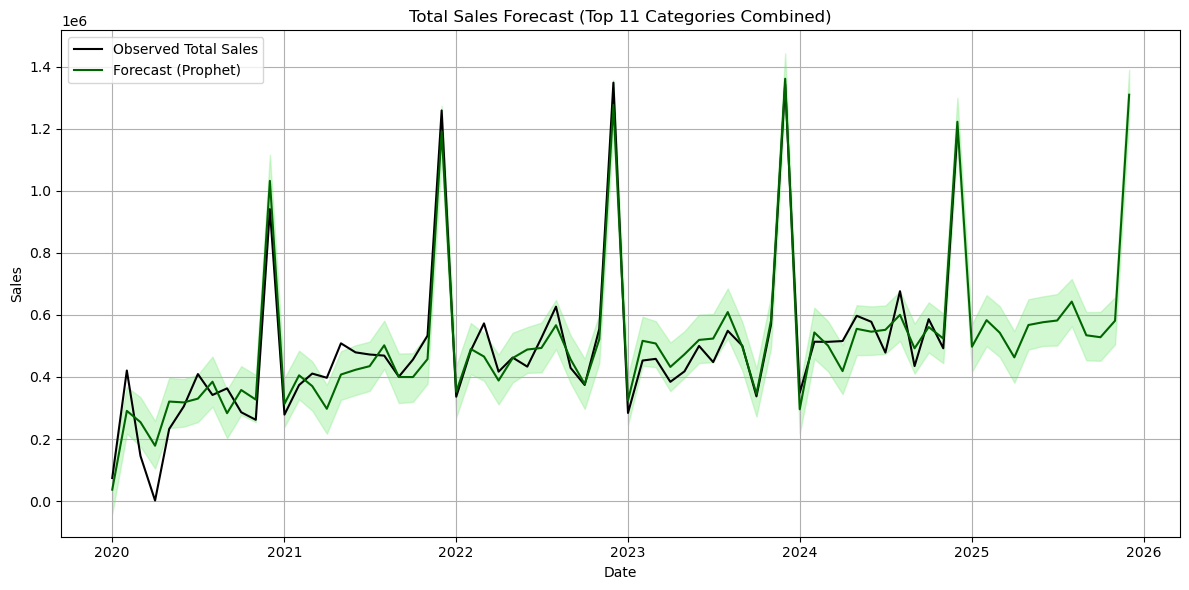

In [28]:
# Query aggregated sales
query = """
    SELECT 
        period AS ds,
        SUM(total_sales) AS y
    FROM `capstone-project-2025-449217.jdc_data.top11_forecast_sales`
    GROUP BY ds
    ORDER BY ds
"""
agg_df = client.query(query).to_dataframe()
agg_df['ds'] = pd.to_datetime(agg_df['ds'])

# Fit Prophet model
from prophet import Prophet

agg_model = Prophet()
agg_model.fit(agg_df)

# Forecast next 12 months
future = agg_model.make_future_dataframe(periods=12, freq='MS')
forecast = agg_model.predict(future)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(agg_df['ds'], agg_df['y'], label='Observed Total Sales', color='black')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast (Prophet)', color='darkgreen')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightgreen', alpha=0.4)
plt.title("Total Sales Forecast (Top 11 Categories Combined)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from prophet import Prophet
import numpy as np
import pandas as pd

# Sort and ensure datetime format
agg_df = agg_df.sort_values("ds")
agg_df["ds"] = pd.to_datetime(agg_df["ds"])

# Train/test split (e.g., last 12 months as test)
train = agg_df[agg_df["ds"] < "2024-01-01"]
test = agg_df[agg_df["ds"] >= "2024-01-01"]

# Fit SARIMA model
sarima_model = SARIMAX(
    train["y"],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Forecast for the test period
n_periods = len(test)
sarima_forecast = sarima_model.forecast(steps=n_periods)

# Evaluate SARIMA
mape_sarima = mean_absolute_percentage_error(test["y"], sarima_forecast) * 100
rmse_sarima = np.sqrt(mean_squared_error(test["y"], sarima_forecast))

print(f"📊 SARIMA Performance:")
print(f"MAPE: {mape_sarima:.2f}%")
print(f"RMSE: ${rmse_sarima:,.2f}")

# Prophet Comparison (optional, if needed)
prophet = Prophet()
prophet.fit(train.rename(columns={"ds": "ds", "y": "y"}))

future = prophet.make_future_dataframe(periods=n_periods, freq="MS")
forecast_prophet = prophet.predict(future)

# Align Prophet forecast with test period
prophet_forecast = forecast_prophet[forecast_prophet["ds"].isin(test["ds"])]

# Evaluate Prophet
mape_prophet = mean_absolute_percentage_error(test["y"], prophet_forecast["yhat"]) * 100
rmse_prophet = np.sqrt(mean_squared_error(test["y"], prophet_forecast["yhat"]))

print(f"\n📊 Prophet Performance:")
print(f"MAPE: {mape_prophet:.2f}%")
print(f"RMSE: ${rmse_prophet:,.2f}")


/Users/juliehilley/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
10:48:33 - cmdstanpy - INFO - Chain [1] start processing
10:48:33 - cmdstanpy - INFO - Chain [1] done processing


📊 SARIMA Performance:
MAPE: 16.44%
RMSE: $118,634.02

📊 Prophet Performance:
MAPE: 15.13%
RMSE: $96,599.05


Inventory Forecasting - Using the Value-Based Approach for Inventory

Step 1: Create a new table with the aggregated forecast values and save it to GBQ

In [30]:
# Select only relevant columns
forecast_export = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()

# Optional: Rename for clarity
forecast_export.rename(columns={
    'ds': 'period',
    'yhat': 'forecasted_sales',
    'yhat_lower': 'forecasted_sales_lower',
    'yhat_upper': 'forecasted_sales_upper'
}, inplace=True)

# Define destination table
table_id = "capstone-project-2025-449217.jdc_data.agg_forecast_sales"

# Upload to BigQuery
job = client.load_table_from_dataframe(forecast_export, table_id, job_config=bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE"  # Overwrite if exists
))
job.result()  # Wait for job to complete

print("✅ Forecast results successfully written to BigQuery!")


✅ Forecast results successfully written to BigQuery!


In [33]:
# Rename for consistency with table schema
forecast_results = forecast_results.rename(columns={
    'ds': 'period',
    'yhat': 'forecasted_sales',
    'yhat_lower': 'forecasted_sales_lower',
    'yhat_upper': 'forecasted_sales_upper'
})

# Reorder columns just to be safe
forecast_results = forecast_results[[
    'category_num', 'category_name', 'period',
    'forecasted_sales', 'forecasted_sales_lower', 'forecasted_sales_upper'
]]

# Optional: round for neatness
forecast_results[['forecasted_sales', 'forecasted_sales_lower', 'forecasted_sales_upper']] = (
    forecast_results[['forecasted_sales', 'forecasted_sales_lower', 'forecasted_sales_upper']].round(2)
)

# Upload to BigQuery
forecast_results.to_gbq(
    destination_table='jdc_data.top11_forecast_sales',
    project_id='capstone-project-2025-449217',
    if_exists='replace'  # use 'append' if you don't want to overwrite existing values
)


/var/folders/0z/mv9ttjcj47b785v4ktts6yjh0000gn/T/ipykernel_1282/2018382016.py:21: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  forecast_results.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 9000.65it/s]


In [34]:
from pandas_gbq import to_gbq

to_gbq(
    forecast_results,
    destination_table='jdc_data.top11_forecast_sales',
    project_id='capstone-project-2025-449217',
    if_exists='replace'
)


100%|██████████| 1/1 [00:00<00:00, 9986.44it/s]


In [31]:
# Step 1: Merge forecast with actual sales (agg_df)
full_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
full_forecast = full_forecast.merge(agg_df[['ds', 'y']], on='ds', how='left')

# Step 2: Rename for clarity
full_forecast.rename(columns={
    'ds': 'period',
    'yhat': 'forecasted_sales',
    'yhat_lower': 'forecasted_sales_lower',
    'yhat_upper': 'forecasted_sales_upper',
    'y': 'actual_sales'
}, inplace=True)

# Step 3: Define table name
table_id = "capstone-project-2025-449217.jdc_data.agg_forecast_sales"

# Step 4: Upload to BigQuery
from google.cloud import bigquery

job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
job = client.load_table_from_dataframe(full_forecast, table_id, job_config=job_config)
job.result()  # Waits for the job to finish

print("✅ Forecast + actuals table successfully written to BigQuery!")


✅ Forecast + actuals table successfully written to BigQuery!


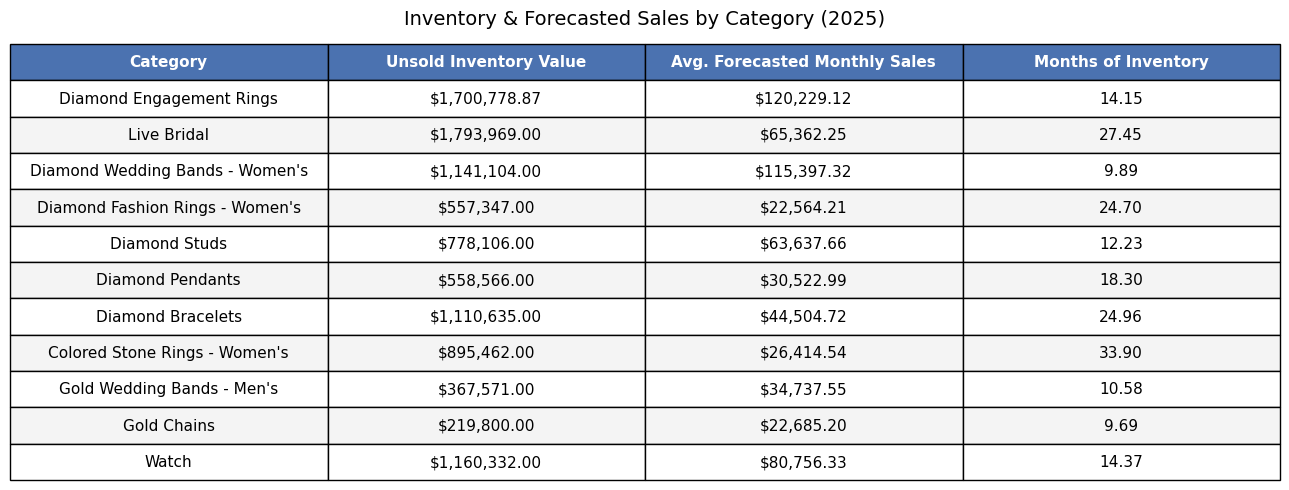

In [52]:
# STEP 1: Load inventory data (unsold inventory value by category)
inventory_query = """
    SELECT
      CAST(category_num AS STRING) AS category_num,
      category_name,
      ROUND(SUM(saleprice), 2) AS total_sale_value
    FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
    WHERE sold_status = 0
      AND CAST(category_num AS STRING) IN ('100', '105', '110', '130', '155', '160', '170', '200', '405', '430', '560')
    GROUP BY category_num, category_name
"""
inventory_df = client.query(inventory_query).to_dataframe()

# STEP 2: Load 2025 forecasted sales data by category
forecast_query = """
    SELECT
      CAST(category_num AS STRING) AS category_num,
      category_name,
      period,
      forecasted_sales
    FROM `capstone-project-2025-449217.jdc_data.top11_forecast_sales`
    WHERE CAST(category_num AS STRING) IN ('100', '105', '110', '130', '155', '160', '170', '200', '405', '430', '560')
      AND EXTRACT(YEAR FROM period) = 2025
"""
forecast_df = client.query(forecast_query).to_dataframe()

# STEP 3: Calculate average monthly forecasted sales for each category
monthly_forecast = (
    forecast_df
    .groupby('category_num')['forecasted_sales']
    .mean()
    .reset_index()
    .rename(columns={'forecasted_sales': 'avg_monthly_forecasted_sales'})
)

# STEP 4: Merge forecast with inventory
merged_df = inventory_df.merge(monthly_forecast, on='category_num', how='left')

# STEP 5: Calculate months of inventory by value
merged_df['months_of_inventory'] = (
    merged_df['total_sale_value'] / merged_df['avg_monthly_forecasted_sales']
).round(2)

# DO NOT format merged_df here — wait until report_df is created

import matplotlib.pyplot as plt

# STEP 6: Create a clean display version for your report
report_df = merged_df[[
    'category_name',
    'total_sale_value',
    'avg_monthly_forecasted_sales',
    'months_of_inventory'
]].copy()

report_df.columns = [
    "Category",
    "Unsold Inventory Value",
    "Avg. Forecasted Monthly Sales",
    "Months of Inventory"
]

# STEP 7: Apply formatting (on this display-only DataFrame)
report_df["Unsold Inventory Value"] = report_df["Unsold Inventory Value"].apply(lambda x: f"${x:,.2f}")
report_df["Avg. Forecasted Monthly Sales"] = report_df["Avg. Forecasted Monthly Sales"].apply(lambda x: f"${x:,.2f}")
report_df["Months of Inventory"] = report_df["Months of Inventory"].apply(lambda x: f"{x:,.2f}")

# STEP 8: Plot the table using matplotlib
fig, ax = plt.subplots(figsize=(13, 5))
ax.axis('off')

table = ax.table(
    cellText=report_df.values,
    colLabels=report_df.columns,
    loc='center',
    cellLoc='center',
    colLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Style headers and rows
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#4B72B0')
    else:
        cell.set_facecolor('#F4F4F4' if row % 2 == 0 else '#FFFFFF')

# STEP 9: Add title and export
plt.title("Inventory & Forecasted Sales by Category (2025)", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig("forecast_inventory_table.png", dpi=300, bbox_inches='tight')
plt.show()




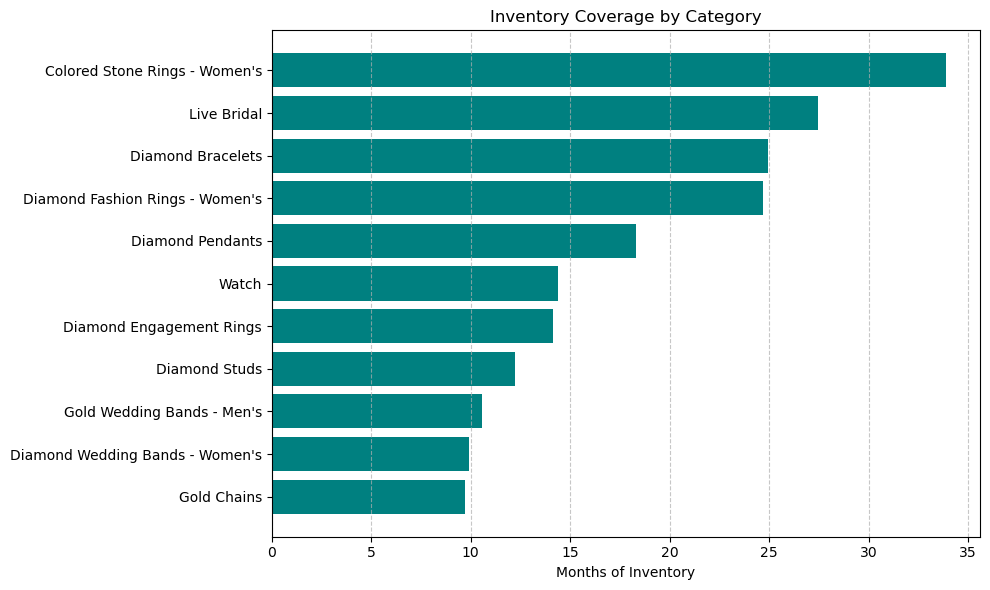

In [43]:
import matplotlib.pyplot as plt

# Convert months_of_inventory back to float for plotting if needed
merged_df['months_of_inventory'] = merged_df['months_of_inventory'].astype(float)

# Sort by months_of_inventory
plot_df = merged_df.sort_values(by='months_of_inventory', ascending=True)

# Create the plot
plt.figure(figsize=(10, 6))
plt.barh(plot_df['category_name'], plot_df['months_of_inventory'], color='teal')
plt.xlabel("Months of Inventory")
plt.title("Inventory Coverage by Category")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


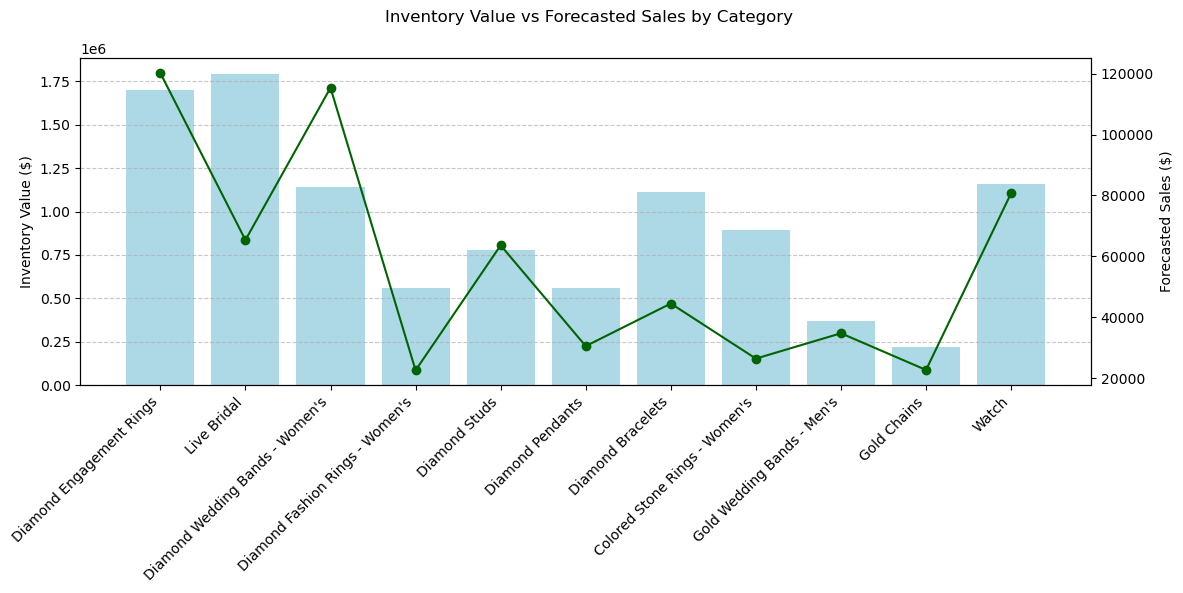

In [44]:
# Convert values back to float
merged_df['total_sale_value'] = merged_df['total_sale_value'].replace('[\$,]', '', regex=True).astype(float)
merged_df['avg_monthly_forecasted_sales'] = merged_df['avg_monthly_forecasted_sales'].replace('[\$,]', '', regex=True).astype(float)

# Set up the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

category_names = merged_df['category_name']
x = range(len(category_names))

# Bar: Inventory value
ax1.bar(x, merged_df['total_sale_value'], color='lightblue', label='Total Inventory Value')
ax1.set_ylabel('Inventory Value ($)')
ax1.set_xticks(x)
ax1.set_xticklabels(category_names, rotation=45, ha='right')

# Line: Forecasted monthly sales
ax2 = ax1.twinx()
ax2.plot(x, merged_df['avg_monthly_forecasted_sales'], color='darkgreen', marker='o', label='Avg Monthly Forecasted Sales')
ax2.set_ylabel('Forecasted Sales ($)')

# Title & legends
fig.suptitle('Inventory Value vs Forecasted Sales by Category')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout()
plt.show()


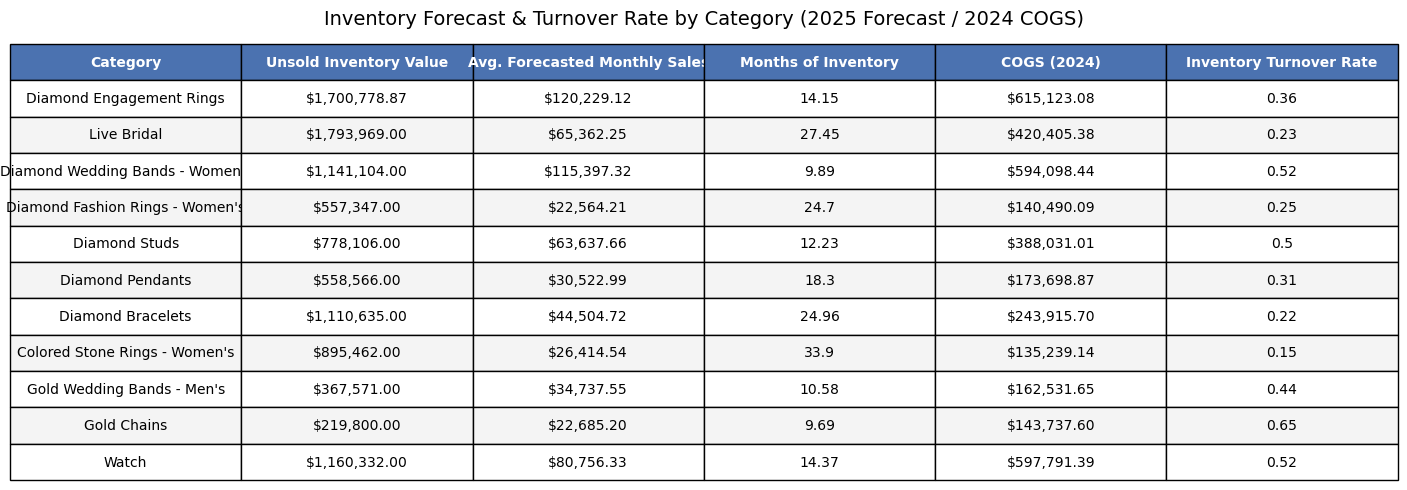

In [53]:
# STEP 1: Load unsold inventory value by category
inventory_query = """
    SELECT
      CAST(category_num AS STRING) AS category_num,
      category_name,
      ROUND(SUM(saleprice), 2) AS total_sale_value
    FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
    WHERE sold_status = 0
      AND CAST(category_num AS STRING) IN ('100', '105', '110', '130', '155', '160', '170', '200', '405', '430', '560')
    GROUP BY category_num, category_name
"""
inventory_df = client.query(inventory_query).to_dataframe()

# STEP 2: Load 2025 forecasted sales data by category
forecast_query = """
    SELECT
      CAST(category_num AS STRING) AS category_num,
      category_name,
      period,
      forecasted_sales
    FROM `capstone-project-2025-449217.jdc_data.top11_forecast_sales`
    WHERE EXTRACT(YEAR FROM period) = 2025
"""
forecast_df = client.query(forecast_query).to_dataframe()

# STEP 3: Average monthly forecasted sales
monthly_forecast = (
    forecast_df
    .groupby('category_num')['forecasted_sales']
    .mean()
    .reset_index()
    .rename(columns={'forecasted_sales': 'avg_monthly_forecasted_sales'})
)

# STEP 4: Load 2024 COGS for turnover calculation
cogs_query = """
    SELECT
      CAST(category_num AS STRING) AS category_num,
      ROUND(SUM(cogs), 2) AS total_cogs
    FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
    WHERE EXTRACT(YEAR FROM sold_date) = 2024
      AND CAST(category_num AS STRING) IN ('100', '105', '110', '130', '155', '160', '170', '200', '405', '430', '560')
    GROUP BY category_num
"""
cogs_df = client.query(cogs_query).to_dataframe()

# STEP 5: Merge all data together
merged_df = (
    inventory_df
    .merge(monthly_forecast, on='category_num', how='left')
    .merge(cogs_df, on='category_num', how='left')
)

# STEP 6: Calculate KPIs
merged_df['months_of_inventory'] = (
    merged_df['total_sale_value'] / merged_df['avg_monthly_forecasted_sales']
).round(2)

merged_df['inventory_turnover'] = (
    merged_df['total_cogs'] / merged_df['total_sale_value']
).round(2)

# STEP 7: Format columns
merged_df['total_sale_value'] = merged_df['total_sale_value'].map('${:,.2f}'.format)
merged_df['avg_monthly_forecasted_sales'] = merged_df['avg_monthly_forecasted_sales'].map('${:,.2f}'.format)
merged_df['total_cogs'] = merged_df['total_cogs'].map('${:,.2f}'.format)

# STEP 8: Reorder for report
report_df = merged_df[[
    'category_name',
    'total_sale_value',
    'avg_monthly_forecasted_sales',
    'months_of_inventory',
    'total_cogs',
    'inventory_turnover'
]].rename(columns={
    'category_name': 'Category',
    'total_sale_value': 'Unsold Inventory Value',
    'avg_monthly_forecasted_sales': 'Avg. Forecasted Monthly Sales',
    'months_of_inventory': 'Months of Inventory',
    'total_cogs': 'COGS (2024)',
    'inventory_turnover': 'Inventory Turnover Rate'
})

# STEP 9: Display table
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 5))
ax.axis('off')

table = ax.table(
    cellText=report_df.values,
    colLabels=report_df.columns,
    loc='center',
    cellLoc='center',
    colLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.1, 2)

for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#4B72B0')
    else:
        cell.set_facecolor('#F4F4F4' if row % 2 == 0 else '#FFFFFF')

plt.title("Inventory Forecast & Turnover Rate by Category (2025 Forecast / 2024 COGS)", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig("inventory_turnover_forecast.png", dpi=300, bbox_inches='tight')
plt.show()


In [54]:
def flag_inventory_risk(row):
    turnover = row['Inventory Turnover Rate']
    months = row['Months of Inventory']

    if turnover >= 0.5 and months <= 12:
        return "🚨 Risk of Stockout"
    elif turnover <= 0.25 and months >= 18:
        return "⚠️ Risk of Overstock"
    else:
        return "✅ Healthy"

# Apply the function to create a new column
report_df["Inventory Health"] = report_df.apply(flag_inventory_risk, axis=1)


In [55]:
def flag_inventory_risk(row):
    turnover = row['Inventory Turnover Rate']
    months = row['Months of Inventory']

    if turnover >= 0.5 and months <= 12:
        return "🚨 Risk of Stockout"
    elif turnover <= 0.25 and months >= 18:
        return "⚠️ Risk of Overstock"
    else:
        return "✅ Healthy"

# Apply the function to create a new column
report_df["Inventory Health"] = report_df.apply(flag_inventory_risk, axis=1)


/var/folders/0z/mv9ttjcj47b785v4ktts6yjh0000gn/T/ipykernel_1282/4158623485.py:26: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig("inventory_health_table.png", dpi=300, bbox_inches='tight')
/var/folders/0z/mv9ttjcj47b785v4ktts6yjh0000gn/T/ipykernel_1282/4158623485.py:26: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.savefig("inventory_health_table.png", dpi=300, bbox_inches='tight')


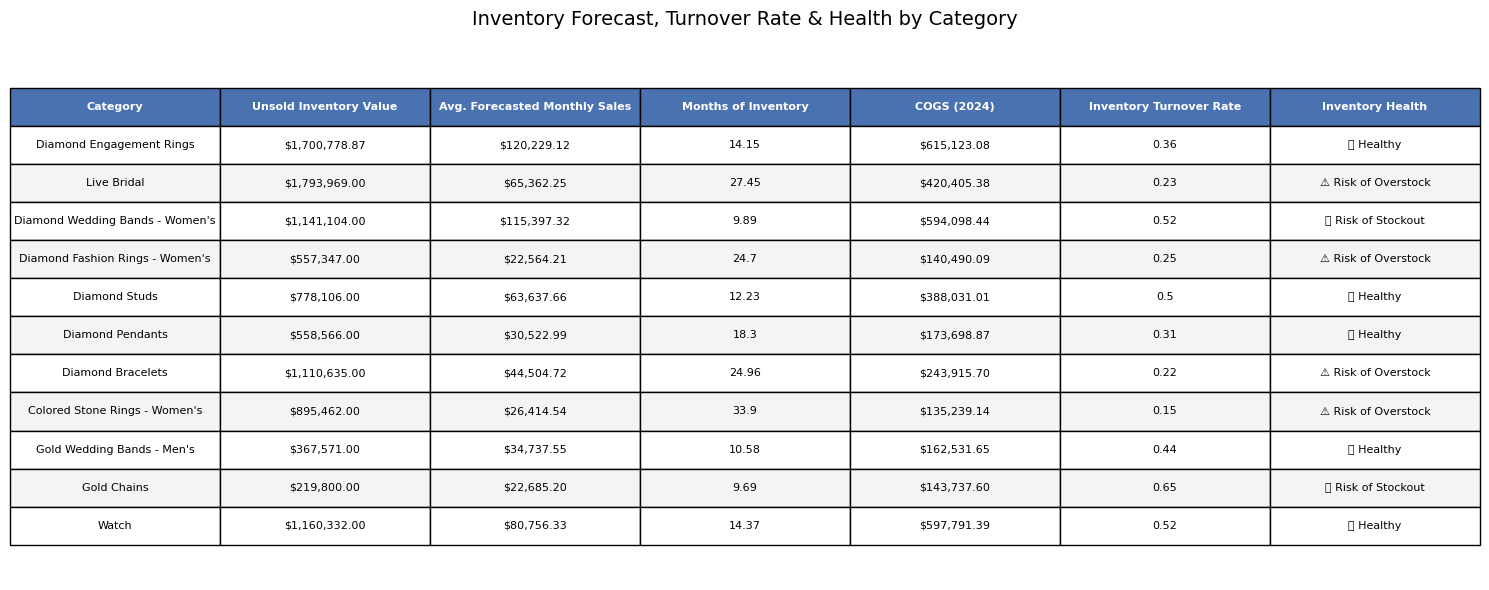

In [58]:
# STEP 4: Plot the updated table
fig, ax = plt.subplots(figsize=(15, 6))
ax.axis('off')

table = ax.table(
    cellText=report_df.values,
    colLabels=report_df.columns,
    loc='center',
    cellLoc='center',
    colLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 2)

for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#4B72B0')
    else:
        cell.set_facecolor('#F4F4F4' if row % 2 == 0 else '#FFFFFF')

plt.title("Inventory Forecast, Turnover Rate & Health by Category", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig("inventory_health_table.png", dpi=300, bbox_inches='tight')
plt.show()


In [60]:
import pandas as pd

# STEP 1: Load unsold inventory value by category (Beginning Inventory)
inventory_query = """
    SELECT
      CAST(category_num AS STRING) AS category_num,
      category_name,
      ROUND(SUM(saleprice), 2) AS total_sale_value
    FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
    WHERE sold_status = 0
      AND CAST(category_num AS STRING) IN ('100', '105', '110', '130', '155', '160', '170', '200', '405', '430', '560')
    GROUP BY category_num, category_name
"""
inventory_df = client.query(inventory_query).to_dataframe()

# STEP 2: Load forecasted sales for Q1 2025
forecast_query = """
    SELECT
      CAST(category_num AS STRING) AS category_num,
      EXTRACT(QUARTER FROM period) AS quarter,
      SUM(forecasted_sales) AS quarterly_forecasted_sales
    FROM `capstone-project-2025-449217.jdc_data.top11_forecast_sales`
    WHERE EXTRACT(YEAR FROM period) = 2025
      AND EXTRACT(QUARTER FROM period) = 1
      AND CAST(category_num AS STRING) IN ('100', '105', '110', '130', '155', '160', '170', '200', '405', '430', '560')
    GROUP BY category_num, quarter
"""
forecast_df = client.query(forecast_query).to_dataframe()

# STEP 3: Merge forecast with inventory (only category_num is shared)
merged_df = inventory_df.merge(forecast_df, on='category_num', how='left')

# STEP 4: Calculate Open-to-Buy
merged_df['open_to_buy'] = merged_df['quarterly_forecasted_sales'] - merged_df['total_sale_value']

# STEP 5: Format columns
merged_df['total_sale_value'] = merged_df['total_sale_value'].map('${:,.2f}'.format)
merged_df['quarterly_forecasted_sales'] = merged_df['quarterly_forecasted_sales'].map('${:,.2f}'.format)
merged_df['open_to_buy'] = merged_df['open_to_buy'].map('${:,.2f}'.format)

# STEP 6: Select and rename final columns
otb_table = merged_df[[
    'category_name',
    'total_sale_value',
    'quarterly_forecasted_sales',
    'open_to_buy'
]].rename(columns={
    'category_name': 'Category',
    'total_sale_value': 'Beginning Inventory (Unsold)',
    'quarterly_forecasted_sales': 'Forecasted Sales (Q1)',
    'open_to_buy': 'Open to Buy'
})

# STEP 7: Display
print(otb_table)


                           Category Beginning Inventory (Unsold)  \
0          Diamond Engagement Rings                $1,700,778.87   
1                       Live Bridal                $1,793,969.00   
2   Diamond Wedding Bands - Women's                $1,141,104.00   
3   Diamond Fashion Rings - Women's                  $557,347.00   
4                     Diamond Studs                  $778,106.00   
5                  Diamond Pendants                  $558,566.00   
6                 Diamond Bracelets                $1,110,635.00   
7     Colored Stone Rings - Women's                  $895,462.00   
8        Gold Wedding Bands - Men's                  $367,571.00   
9                       Gold Chains                  $219,800.00   
10                            Watch                $1,160,332.00   

   Forecasted Sales (Q1)     Open to Buy  
0            $325,881.51  $-1,374,897.36  
1            $170,025.54  $-1,623,943.46  
2            $313,928.81    $-827,175.19  
3          